In [93]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import itertools
import seaborn as sns

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask


plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [ ]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'

# model_array_dir = [f'dim_specific_loss_{i}' for i in range(1,9)]
model_array_dir = [f'test{i}' for i in range(1,9)]

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'go_cue': (1, [0]),
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    'reward': (2, [0]), 
    'action_chosen': (2, [0]), 
}

output_config = {
    'action': (2, [0], True), # action value decoding, left, right, 
    'stimulus': (args['stim_dims']*2, [0], True), # stimulus value decoding,stimulus
    'block_type': (2, [0], True), # block type decoding, where or what block
    
    # decode the desired direction for next choice, separately for block types
    # detach gradient so that they don't affect the rest of the model
    'dv_loc': (2, [0], True), # desired location based on previous trial outcome
    'dv_stim': (2, [0], True), # location of desired stimulus based on previous trial outcome
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')
E_SIZE = int(args['hidden_size']*args['e_prop'])

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

In [91]:
def test_model(all_models, test_samples=4):
    for model in all_models:
        model.eval()

    results_dict = {
        'model_index': [], # num_blocks
        'reversal_interval': [], # num_blocks
        'block_type': [], # num_blocks
        'stimulus': [], # num_blocks X num_trials
        'inputs': [], # num_blocks X num_trials X 2*num_dims
        'img_chosen': [], # num_blocks X num_trials
        'loc_chosen': [], # num_blocks X num_trials
        'reward': [], # num_blocks X num_trials
        'reward_probs': [], # num_blocks X num_trials X 2
        'neuron_states': [], # num_blocks X num_trials X num_timesteps X num_units
        'synaptic_states': [] # num_blocks X num_trials X num_units X num_units
    }

    mdl_indices = list(range(len(all_models)))
    block_type_indices = list(range(2))
    reversal_interval_indices = [30, 35, 40, 45, 50]
    
    indices_product = list(itertools.product(mdl_indices, block_type_indices, reversal_interval_indices))

    with torch.no_grad():
        for mdl_idx, test_block_type, test_reversal_interval in indices_product:
            print(f'Testing model {mdl_idx} with block type {test_block_type} and reversal interval {test_reversal_interval}')
            for _ in range(test_samples):
                trial_info = what_where_task.generate_trials(
                    batch_size = args['batch_size'],
                    trials_per_block = args['trials_per_test_block'], 
                    reversal_interval = [test_reversal_interval, test_reversal_interval],
                    reward_schedule=[args['reward_probs_high'], 1-args['reward_probs_high']],
                    block_type=test_block_type,
                ) 
                stim_inputs = trial_info['stim_inputs'].to(device, dtype=torch.float)
                rewards = trial_info['rewards'].to(device)
                
                hidden, w_hidden = model.init_hidden(args['batch_size'], device)

                results_dict['model_index'].append(mdl_idx)
                results_dict['reversal_interval'].append(test_reversal_interval)
                results_dict['block_type'].append(test_block_type)
                results_dict['stimulus'].append(trial_info['stim_configs'])
                results_dict['inputs'].append(trial_info['stim_inputs'])
                results_dict['reward_probs'].append(trial_info['reward_probs'])

                results_dict['img_chosen'].append([])
                results_dict['loc_chosen'].append([])
                results_dict['reward'].append([])
                
                results_dict['neuron_states'].append([])
                results_dict['synaptic_states'].append([])
                
                for i in range(len(stim_inputs)):
                    results_dict['neuron_states'][-1].append([])
                    ''' first phase, give nothing '''
                    all_x = {
                        'fixation': torch.zeros(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action_chosen': torch.zeros(args['batch_size'], 2, device=device), # left/right  
                    }

                    _, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_ITI, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    DAs=None, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    
                    ''' second phase, give fixation '''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': torch.zeros_like(stim_inputs[i]),
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action_chosen': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    _, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_fixation, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    DAs=None, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' third phase, give stimuli and no feedback '''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],
                        'reward': torch.zeros(args['batch_size'], 2, device=device), # 2+2 for chosen and unchosen rewards
                        'action_chosen': torch.zeros(args['batch_size'], 2, device=device), # left/right
                    }

                    output, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_stim, 
                                                        neumann_order=0,
                                                        hidden=hidden, w_hidden=w_hidden, 
                                                        DAs=None, save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)

                    ''' use output to calculate action, reward, and record loss function '''
                    action = torch.multinomial(output['action'].softmax(-1), num_samples=1).squeeze(-1) # (batch size, )
                    rwd_ch = rewards[i][torch.arange(args['batch_size']),action] # (batch size, )
                    
                    results_dict['img_chosen'][-1].append((action!=trial_info['stim_configs'][i])*1)
                    # (loc_choice, config)->img_chosen, (0,0)->0, (1,0)->1, (0,1)->1, (1,1)->0
                    results_dict['loc_chosen'][-1].append(action)
                    results_dict['reward'][-1].append(rwd_ch)

                    '''fourth phase, give stimuli and choice, and update weights'''
                    all_x = {
                        'fixation': torch.ones(args['batch_size'], 1, device=device),
                        'stimulus': stim_inputs[i],  # only chosen stimulus input, zero the other one
                        'reward': torch.eye(2, device=device)[None][torch.arange(args['batch_size']), rwd_ch], # reward/reward
                        'action_chosen': torch.eye(2, device=device)[None][torch.arange(args['batch_size']), action], # left/right
                    }

                    output, hidden, w_hidden, hs = all_models[mdl_idx](all_x, steps=what_where_task.T_choice_reward, 
                                                    neumann_order=0,
                                                    hidden=hidden, w_hidden=w_hidden, 
                                                    DAs=(2*rwd_ch-1), save_all_states=True)
                    results_dict['neuron_states'][-1][-1].append(hs)
                    results_dict['synaptic_states'][-1].append(w_hidden)

                    results_dict['neuron_states'][-1][-1] = np.concatenate(results_dict['neuron_states'][-1][-1], axis=0) # num_timesteps, batch_size, num_dims

            # collect results in 
            results_dict['img_chosen'][-1] = np.array(results_dict['img_chosen'][-1]) # num_trials X batch_size
            results_dict['loc_chosen'][-1] = np.array(results_dict['loc_chosen'][-1]) # num_trials X batch_size 
            results_dict['reward'][-1] = np.array(results_dict['reward'][-1]) # num_trials X batch_size

            results_dict['neuron_states'][-1] = np.stack(results_dict['neuron_states'][-1]) # num_trials, num_timesteps, batch_size, num_dims
            results_dict['synaptic_states'][-1] = np.stack(results_dict['synaptic_states'][-1]) # num_trials X batch_size X num_dims X num_dims
        
    for k, v in results_dict.items():
        results_dict[k] = np.stack(v)

    for k, v in results_dict.items():
        print(k, v.shape)

    return results_dict


In [92]:
import pickle

test_activities_dir = '/dartfs/rc/lab/S/SoltaniA/f005d7d/what_where_analysis/rnn_test_activities/test_activities.pkl'

# if os.path.exists(test_activities_dir):
#     print('found previous record pickle, loading previous results')
#     with open(test_activities_dir, 'rb') as f:
#         all_saved_states = pickle.load(f)
#     print('loaded previous results')
# else:
all_saved_states = test_model(all_models, test_samples=10)
print('simulation complete')
with open(test_activities_dir, 'wb') as f:
    pickle.dump(all_saved_states, f)
print(f'saved results to {test_activities_dir}')

Testing model 0 with block type 0 and reversal interval 30


TypeError: relu(): argument 'input' (position 1) must be Tensor, not NoneType

# Behavioral analysis

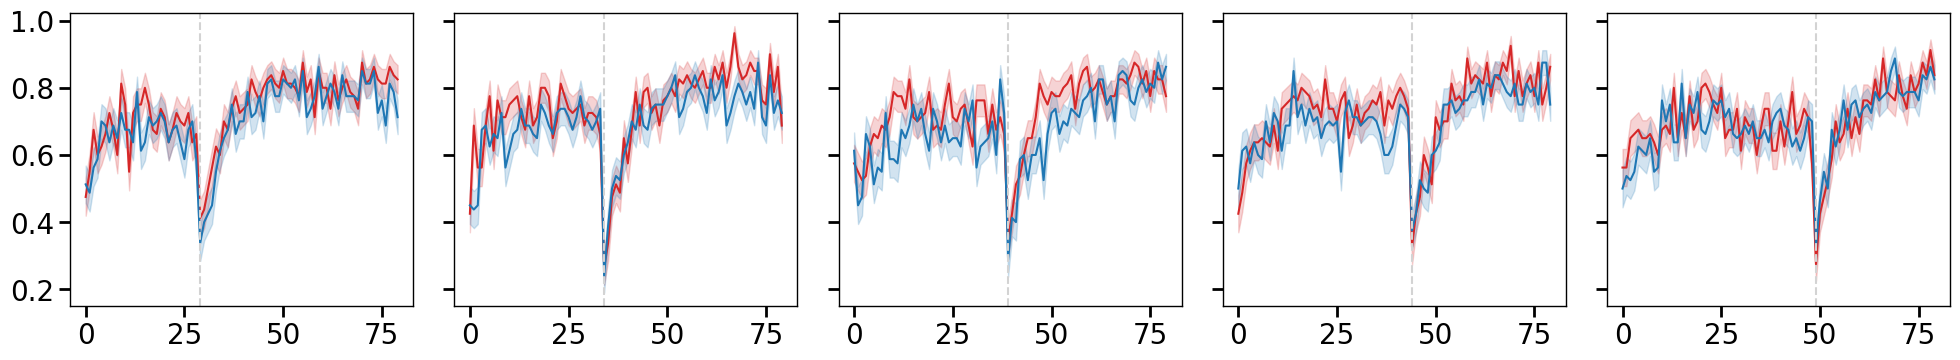

In [5]:
def learning_curves(results_dict):
    # calculate the performance for all models based on the chosen location

    performance = (results_dict['loc_chosen']==np.argmax(results_dict['reward_probs'], axis=-1)).squeeze()
    
    w_size = 1
    performance = np.stack([
        np.convolve(perf, np.ones(w_size)/w_size, mode='valid') for perf in performance
    ])

    where_blocks_mask = results_dict['block_type']==0
    what_blocks_mask = results_dict['block_type']==1
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
    
    for reversal_idx, reversal_interval in enumerate([30, 35, 40, 45, 50]):
        reversal_interval_mask = results_dict['reversal_interval']==reversal_interval

        where_blocks_performance = performance[where_blocks_mask&reversal_interval_mask]
        what_blocks_performance = performance[what_blocks_mask&reversal_interval_mask]

        axes[reversal_idx].plot(what_blocks_performance.mean(0), label='What blocks', color='tab:red')
        axes[reversal_idx].plot(where_blocks_performance.mean(0), label='Where blocks', color='tab:blue')

        axes[reversal_idx].fill_between(np.arange(performance.shape[1]), 
                         what_blocks_performance.mean(0)-what_blocks_performance.std(0)/np.sqrt(what_blocks_performance.shape[0]), 
                         what_blocks_performance.mean(0)+what_blocks_performance.std(0)/np.sqrt(what_blocks_performance.shape[0]), 
                         color='tab:red', alpha=0.2)
        axes[reversal_idx].fill_between(np.arange(performance.shape[1]), 
                         where_blocks_performance.mean(0)-where_blocks_performance.std(0)/np.sqrt(where_blocks_performance.shape[0]), 
                         where_blocks_performance.mean(0)+where_blocks_performance.std(0)/np.sqrt(where_blocks_performance.shape[0]), 
                         color='tab:blue', alpha=0.2)
        axes[reversal_idx].axvline(reversal_interval-1, c='lightgrey', ls='--')
    
#     plt.legend()
    plt.tight_layout()
    plt.show()
    return

learning_curves(all_saved_states)


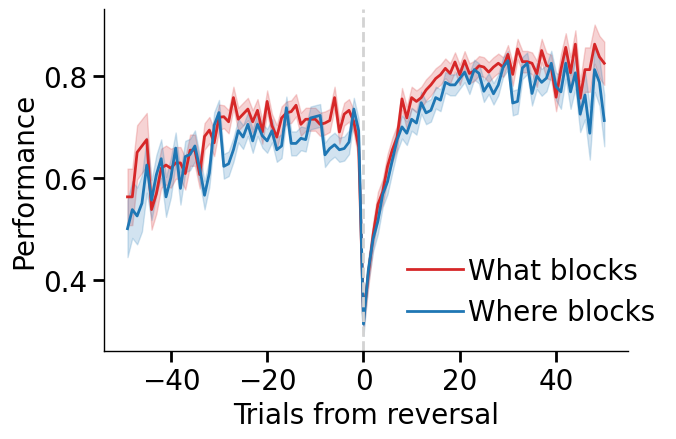

In [6]:
def learning_curves_align_to_reversal(results_dict):
    # calculate the performance for all models based on the chosen location

    performance = (results_dict['loc_chosen']==np.argmax(results_dict['reward_probs'], axis=-1)).squeeze()
    
    w_size = 1
    performance = np.stack([
        np.convolve(perf, np.ones(w_size)/w_size, mode='valid') for perf in performance
    ])

    where_blocks_mask = results_dict['block_type']==0
    what_blocks_mask = results_dict['block_type']==1
    
    # Initialize lists to store aligned performance data
    all_where_aligned = []
    all_what_aligned = []
    
    # Aggregate over all reversal intervals
    for reversal_interval in [30, 35, 40, 45, 50]:
        reversal_interval_mask = results_dict['reversal_interval']==reversal_interval

        where_blocks_performance = performance[where_blocks_mask&reversal_interval_mask]
        what_blocks_performance = performance[what_blocks_mask&reversal_interval_mask]

        # Align performance to reversal point
        padded_where_blocks_performance = np.nan*np.empty((where_blocks_performance.shape[0], 100))
        padded_what_blocks_performance = np.nan*np.empty((what_blocks_performance.shape[0], 100))
        
        start_idx = 50 - reversal_interval
        end_idx = 130 - reversal_interval
        padded_where_blocks_performance[:, start_idx:end_idx] = where_blocks_performance
        padded_what_blocks_performance[:, start_idx:end_idx] = what_blocks_performance
        
        # Store aligned data
        all_where_aligned.append(padded_where_blocks_performance)
        all_what_aligned.append(padded_what_blocks_performance)
    
    # Concatenate all aligned performance data
    all_where_aligned = np.concatenate(all_where_aligned, axis=0)
    all_what_aligned = np.concatenate(all_what_aligned, axis=0)

#     all_where_aligned = all_where_aligned[:, 10:90]
#     all_what_aligned = all_what_aligned[:, 10:90]
    
    # Create single plot showing aggregated results
    fig, ax = plt.subplots(1, 1, figsize=(7.2, 4.8))
    
    # Create aligned x-axis centered on reversal point
    x_aligned = np.arange(-all_what_aligned.shape[1]//2, all_what_aligned.shape[1]//2)+1
    
    # Plot aggregated learning curves
    ax.plot(x_aligned, np.nanmean(all_what_aligned, 0), label='What blocks', color='tab:red', linewidth=2)
    ax.plot(x_aligned, np.nanmean(all_where_aligned, 0), label='Where blocks', color='tab:blue', linewidth=2)

    # Add error bars (standard error of the mean) using nanmean and nanstd
    ax.fill_between(
        x_aligned,
        np.nanmean(all_what_aligned, axis=0) - np.nanstd(all_what_aligned, axis=0)/np.sqrt(np.sum(~np.isnan(all_what_aligned), axis=0)),
        np.nanmean(all_what_aligned, axis=0) + np.nanstd(all_what_aligned, axis=0)/np.sqrt(np.sum(~np.isnan(all_what_aligned), axis=0)),
        color='tab:red', alpha=0.2
    )
    ax.fill_between(
        x_aligned,
        np.nanmean(all_where_aligned, axis=0) - np.nanstd(all_where_aligned, axis=0)/np.sqrt(np.sum(~np.isnan(all_where_aligned), axis=0)),
        np.nanmean(all_where_aligned, axis=0) + np.nanstd(all_where_aligned, axis=0)/np.sqrt(np.sum(~np.isnan(all_where_aligned), axis=0)),
        color='tab:blue', alpha=0.2
    )
    
    # Mark the reversal point at x=0
    ax.axvline(0, c='lightgrey', ls='--', linewidth=2)
    
    # Formatting
    ax.set_ylabel('Performance')
    ax.set_xlabel('Trials from reversal')
    ax.legend(loc='lower right', bbox_to_anchor=(1.1,0.), frameon=False, handletextpad=0.2)
    
    plt.tight_layout()
    sns.despine()
    plt.savefig(os.path.join(figure_data_dir, "RNN_learning_curves.pdf"), bbox_inches='tight')
    return

learning_curves_align_to_reversal(all_saved_states)




In [7]:
all_saved_states.keys()

dict_keys(['model_index', 'reversal_interval', 'block_type', 'stimulus', 'inputs', 'img_chosen', 'loc_chosen', 'reward', 'reward_probs', 'neuron_states', 'synaptic_states'])

In [41]:
def stay_probs(results_dict):
    # calculate the probability of staying with the same location and stimulus choice given previous trial's reward outcomes
    # results_dict: dict of results from the model
    # return: dict of stay probabilities

    num_blocks, num_trials, _ = results_dict['reward'].shape
    stay_probs = {
        'what_unrewarded_loc': [],
        'what_rewarded_loc': [],
        'where_unrewarded_loc': [],
        'where_rewarded_loc': [],
        'what_unrewarded_img': [],
        'what_rewarded_img': [],
        'where_unrewarded_img': [],
        'where_rewarded_img': [],
    }
    all_block_stay_probs = np.nan*np.empty((num_blocks, 4)) # [unrewarded, rewarded] X [loc, img]

    for block_idx in range(num_blocks):
        block_type = results_dict['block_type'][block_idx]
        reward = results_dict['reward'][block_idx]
        img_chosen = results_dict['img_chosen'][block_idx]
        loc_chosen = results_dict['loc_chosen'][block_idx]

        reward_prev = np.isclose(reward[:-1], 1).squeeze()
        # reward_prev = reward_prev & is_correct[block_idx][:-1,0]
        unreward_prev = np.isclose(reward[:-1], 0).squeeze()
        # unreward_prev = unreward_prev & is_correct[block_idx][:-1,0]

        if block_type == 0:
            stay_probs['where_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['where_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['where_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['where_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
            all_block_stay_probs[block_idx] = [stay_probs['where_unrewarded_loc'][-1], 
                                              stay_probs['where_unrewarded_img'][-1],
                                              stay_probs['where_rewarded_loc'][-1],
                                              stay_probs['where_rewarded_img'][-1]]
        elif block_type == 1:
            stay_probs['what_unrewarded_loc'].append(np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev]))
            stay_probs['what_unrewarded_img'].append(np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev]))
            stay_probs['what_rewarded_loc'].append(np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev]))
            stay_probs['what_rewarded_img'].append(np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev]))
            all_block_stay_probs[block_idx] = [stay_probs['what_unrewarded_loc'][-1], 
                                              stay_probs['what_unrewarded_img'][-1],
                                              stay_probs['what_rewarded_loc'][-1],
                                              stay_probs['what_rewarded_img'][-1]]
        else:
            raise ValueError
            


    return stay_probs, all_block_stay_probs

all_stay_probs, all_block_stay_probs = stay_probs(all_saved_states)


In [42]:
diff_responses_loc_what_blocks = np.array(all_stay_probs['what_rewarded_loc'])-np.array(all_stay_probs['what_unrewarded_loc'])
diff_responses_img_what_blocks = np.array(all_stay_probs['what_rewarded_img'])-np.array(all_stay_probs['what_unrewarded_img'])

diff_responses_loc_where_blocks = np.array(all_stay_probs['where_rewarded_loc'])-np.array(all_stay_probs['where_unrewarded_loc'])
diff_responses_img_where_blocks = np.array(all_stay_probs['where_rewarded_img'])-np.array(all_stay_probs['where_unrewarded_img'])



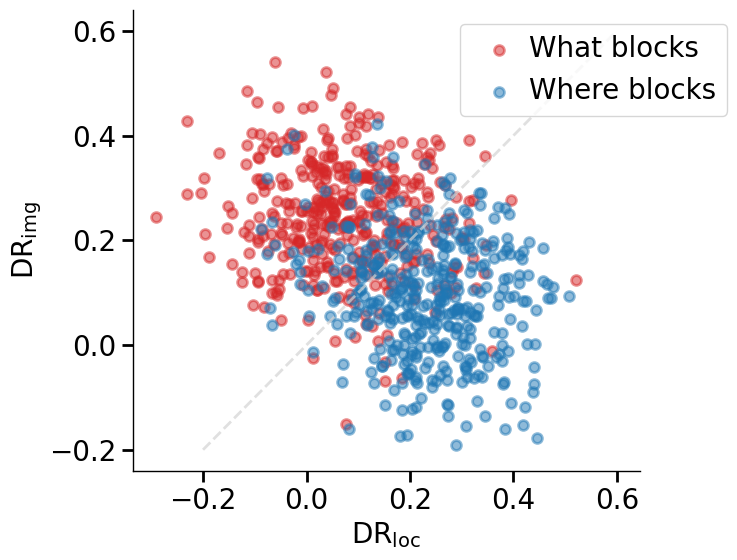

In [43]:
fig, axes = plt.subplots(1,1, figsize=(8,6))

axes.plot([-0.2, 0.6], [-0.2, 0.6], c='lightgrey', ls='--', linewidth=2, alpha=0.7)
axes.scatter(diff_responses_loc_what_blocks, diff_responses_img_what_blocks, 
             color='tab:red', label='What blocks', s=50, alpha=0.5, lw=2)
axes.scatter(diff_responses_loc_where_blocks, diff_responses_img_where_blocks, 
             color='tab:blue', label='Where blocks', s=50, alpha=0.5, lw=2)


axes.set_ylabel(r'$DR_{img}$')
axes.set_xlabel(r'$DR_{loc}$')
axes.legend(loc='upper right', bbox_to_anchor=(1.2, 1.), handletextpad=0.1)

fig.tight_layout()
sns.despine()

plt.savefig(os.path.join(figure_data_dir, "RNN_DR_scatter.pdf"), bbox_inches='tight')


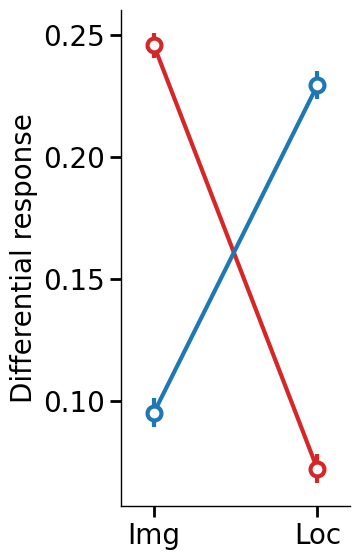

In [38]:
# Calculate mean and standard error for the differences
mean_what = np.mean(diff_responses_img_what_blocks - diff_responses_loc_what_blocks)
se_what = np.std(diff_responses_img_what_blocks - diff_responses_loc_what_blocks, ddof=1) / np.sqrt(len(diff_responses_img_what_blocks))

mean_where = np.mean(diff_responses_img_where_blocks - diff_responses_loc_where_blocks)
se_where = np.std(diff_responses_img_where_blocks - diff_responses_loc_where_blocks, ddof=1) / np.sqrt(len(diff_responses_img_where_blocks))

# Bar height and errors
bar_means = [np.mean(diff_responses_img_what_blocks), np.mean(diff_responses_loc_what_blocks), 
             np.mean(diff_responses_img_where_blocks), np.mean(diff_responses_loc_where_blocks)]
bar_ses = [
    np.std(diff_responses_img_what_blocks, ddof=1)/np.sqrt(len(diff_responses_img_what_blocks)),
    np.std(diff_responses_loc_what_blocks, ddof=1)/np.sqrt(len(diff_responses_loc_what_blocks)),
    np.std(diff_responses_img_where_blocks, ddof=1)/np.sqrt(len(diff_responses_img_where_blocks)),
    np.std(diff_responses_loc_where_blocks, ddof=1)/np.sqrt(len(diff_responses_loc_where_blocks)),
]

# Inset axes for the bar plot
fig, axes = plt.subplots(1,1,figsize=(4, 6))

x = np.arange(2)
# axes.bar(x, bar_means, color=colors)

axes.errorbar(x, bar_means[:2], yerr=bar_ses[:2], fmt='-o', color='tab:red', 
              capsize=0, label='What blocks', ms=10, lw=3, mew=3, mfc='white')
axes.errorbar(x, bar_means[2:], yerr=bar_ses[2:], fmt='-o', color='tab:blue', 
              capsize=0, label='Where blocks', ms=10, lw=3, mew=3, mfc='white')
axes.set_xticks(x, labels=['Img', 'Loc'])
axes.set_xlim([-0.2, 1.2])
axes.set_ylabel('Differential response')

sns.despine()

# axes.legend(loc='best',  handletextpad=0.1)

fig.tight_layout()
plt.savefig(os.path.join(figure_data_dir, "RNN_DR_avg.pdf"), bbox_inches='tight')


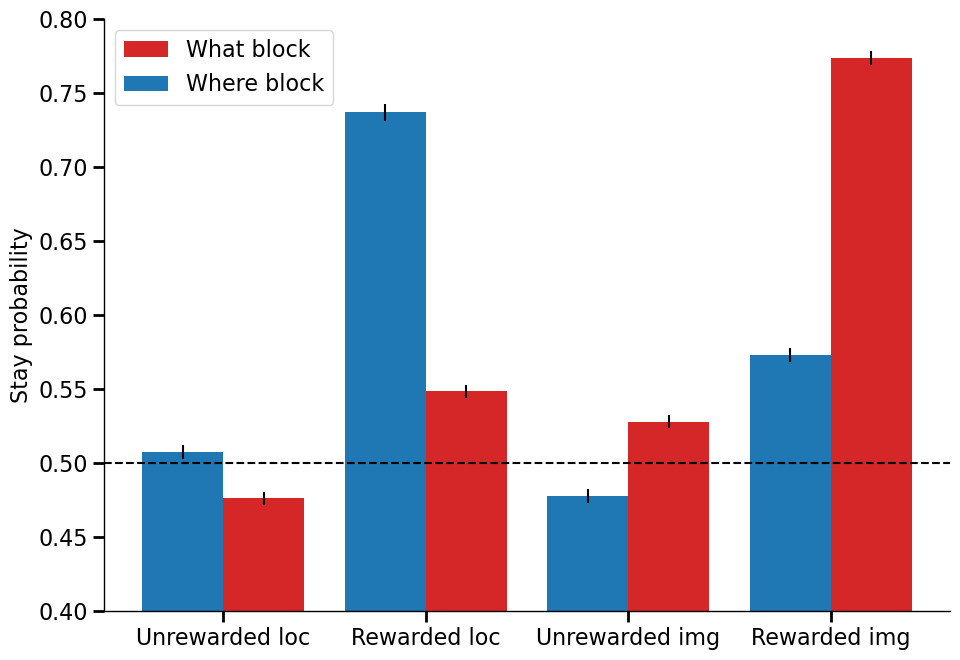

In [39]:
# plot the average stay probabilities in bar plot

stay_probs_what_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'what' in k
]

stay_probs_where_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'where' in k
]

stay_probs_what_blocks = np.array(stay_probs_what_blocks)
stay_probs_where_blocks = np.array(stay_probs_where_blocks)

plt.bar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], color='tab:red', label='What block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], 
             yerr=stay_probs_what_blocks[:,1], color='black', fmt='none')
plt.bar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], color='tab:blue', label='Where block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], 
             yerr=stay_probs_where_blocks[:,1], color='black', fmt='none')
plt.axhline(0.5, ls='--', c='k')

plt.xticks(np.arange(len(stay_probs_what_blocks)), ['Unrewarded loc', 'Rewarded loc', 'Unrewarded img', 'Rewarded img'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Stay probability', fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.4, 0.8])

plt.tight_layout()

sns.despine()

plt.show()






# Example connectivitiy and learning rates

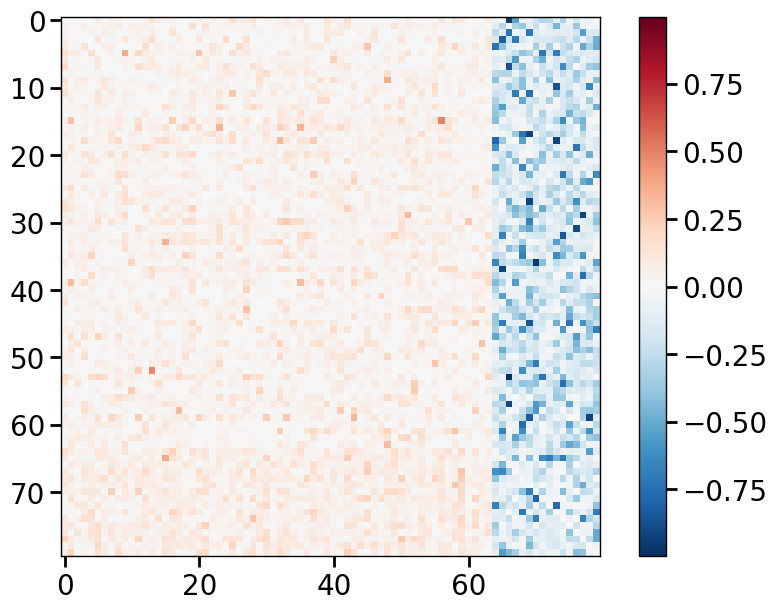

In [239]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].rnn.h2h.effective_weight().detach(), cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()


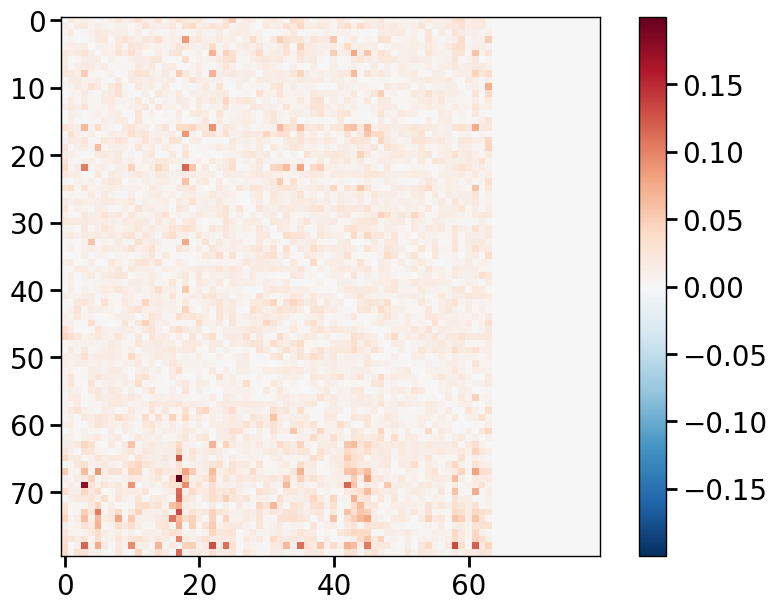

In [240]:
plt.imshow(all_models[np.random.randint(0, len(all_models))].plasticity.effective_lr().detach(),  cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()

# Decomposition of input and output weights subspaces

We want the following dimensions: 
1. Stim dimensions (size 2)
2. Choice readout dimension (size 1)
3. Action feedback dimension (size 1)
4. Reward dimension (size 1)
5. Block type dimension (size 1)

In [241]:
'''decompose the stimulusinput weights'''
all_model_input_weights_raw = []
for mdl in all_models:
    all_model_input_weights_raw.append(mdl.rnn.x2h['stimulus'].effective_weight().detach())
all_model_input_weights_raw = torch.stack(all_model_input_weights_raw, dim=0).reshape(-1, args['hidden_size'], 4) # (num_models, hidden_size, 4)
all_model_inputs_effective = all_model_input_weights_raw @ np.array([[1,0,-1,0], 
                                                                     [0,1,0,-1]]).T[None] 

'''decompose the stimulus output weights'''
all_model_stim_output_weights_raw = []
for mdl in all_models:
    all_model_stim_output_weights_raw.append(mdl.h2o['stimulus'].effective_weight().detach())
all_model_stim_output_weights_raw = torch.stack(all_model_stim_output_weights_raw, dim=0).reshape(-1, 4, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_stim_output_weights_effective = (all_model_stim_output_weights_raw[:,:,[1,3]]-all_model_stim_output_weights_raw[:,:,[2,0]])
# all_model_stim_output_weights_effective = all_model_stim_output_weights_raw-all_model_stim_output_weights_raw.mean(1, keepdims=True)

'''decompose the chosen stimulus weights'''
# all_model_chosen_stim_weights = []
# for mdl in all_models:
#     all_model_chosen_stim_weights.append(mdl.rnn.x2h['stim_chosen'].effective_weight().detach())
# all_model_chosen_stim_weights_raw = torch.stack(all_model_chosen_stim_weights, dim=0) # (num_models, hidden_size, 2)
# all_model_chosen_stim_weights_effective = all_model_chosen_stim_weights_raw-all_model_chosen_stim_weights_raw.mean(1, keepdims=True)

'''============================================'''

'''decompose the output weights'''
all_model_output_weights_raw = []
for mdl in all_models:
    all_model_output_weights_raw.append(mdl.h2o['action'].effective_weight().detach())
all_model_output_weights_raw = torch.stack(all_model_output_weights_raw, dim=0).reshape(-1, 2, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_output_weights_effective = (all_model_output_weights_raw[:,:,1]-all_model_output_weights_raw[:,:,0])[...,None]


'''decompose the value update weights'''
all_model_dv_loc_weights_raw = []
for mdl in all_models:
    all_model_dv_loc_weights_raw.append(mdl.h2o['dv_loc'].effective_weight().detach())
all_model_dv_loc_weights_raw = torch.stack(all_model_dv_loc_weights_raw, dim=0).reshape(-1, 2, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_dv_loc_weights_effective = (all_model_dv_loc_weights_raw[:,:,1]-all_model_dv_loc_weights_raw[:,:,0])[...,None]

all_model_dv_img_weights_raw = []
for mdl in all_models:
    all_model_dv_img_weights_raw.append(mdl.h2o['dv_stim'].effective_weight().detach())
all_model_dv_img_weights_raw = torch.stack(all_model_dv_img_weights_raw, dim=0).reshape(-1, 2, args['hidden_size']).permute(0,2,1) # (num_models, hidden_size, 4)
all_model_dv_img_weights_effective = (all_model_dv_img_weights_raw[:,:,1]-all_model_dv_img_weights_raw[:,:,0])[...,None]


'''decompose the action feedback weights'''
all_model_action_feedback_weights = []
for mdl in all_models:
    all_model_action_feedback_weights.append(mdl.rnn.x2h['action_chosen'].effective_weight().detach())
all_model_action_feedback_weights = torch.stack(all_model_action_feedback_weights, dim=0) # (num_models, hidden_size, 2)
all_model_action_feedback_weights_effective = (all_model_action_feedback_weights[:,:,1]-all_model_action_feedback_weights[:,:,0])[...,None]

'''============================================'''

# # orthognalize the action feedback weights from the readout with qr decomposition
# all_model_action_feedback_weights_effective = np.linalg.qr(
#     np.concatenate([all_model_outputs_effective, all_model_action_feedback_weights_effective], axis=-1))[0][...,-1][...,None]

'''decompose the reward weights'''
all_model_reward_weights = []
for mdl in all_models:
    all_model_reward_weights.append(mdl.rnn.x2h['reward'].effective_weight().detach())
all_model_reward_weights = torch.stack(all_model_reward_weights, dim=0) # (num_models, hidden_size, 2)
all_model_reward_weights_effective = (all_model_reward_weights[:,:,1]-all_model_reward_weights[:,:,0])[...,None]

'''decompose the fixation weights'''
all_model_fixation_weights = []
for mdl in all_models:
    all_model_fixation_weights.append(mdl.rnn.x2h['fixation'].effective_weight().detach())
all_model_fixation_weights = torch.stack(all_model_fixation_weights, dim=0) # (num_models, hidden_size, 1)
all_model_fixation_weights_effective = all_model_fixation_weights

'''decompose the go_cue weights'''
all_model_go_weights = []
for mdl in all_models:
    all_model_go_weights.append(mdl.rnn.x2h['go_cue'].effective_weight().detach())
all_model_go_weights = torch.stack(all_model_go_weights, dim=0) # (num_models, hidden_size, 1)
all_model_go_weights_effective = all_model_go_weights

# orthogonalize the fixation weights from the readout with gram schmidt
# all_model_fixation_weights_effective = all_model_fixation_weights_effective - all_model_fixation_weights_effective@all_model_output_weights_effective[...,1][:,None]/np.linalg.norm()


'''decompose the block type weights'''
all_model_block_type_weights = []
for mdl in all_models:
    all_model_block_type_weights.append(mdl.h2o['block_type'].effective_weight().detach().T)
all_model_block_type_weights = torch.stack(all_model_block_type_weights, dim=0) # (num_models, hidden_size, 2)
all_model_block_type_weights_effective = (all_model_block_type_weights[:,:,1]-all_model_block_type_weights[:,:,0])[...,None]


'''save all the model biases'''
all_model_biases = []
for mdl in all_models:
    all_model_biases.append(mdl.rnn.h2h.bias.detach().numpy())
all_model_biases = np.stack(all_model_biases, axis=0)[...,None] # (num_models, hidden_size)




/scratch/f005d7d/ipykernel_1251725/602797914.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  all_model_inputs_effective = all_model_input_weights_raw @ np.array([[1,0,-1,0],


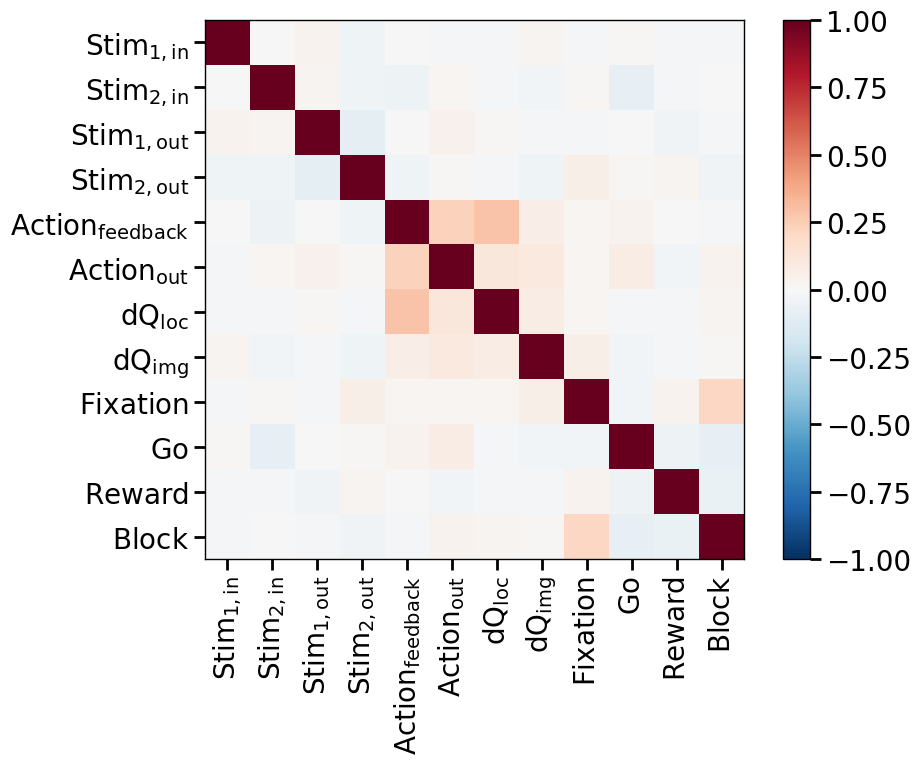

In [242]:
'''calculate the overlap between the bases'''
# ignoring the fixation related bases for now
all_model_bases = np.concatenate([all_model_inputs_effective, 
                                  all_model_stim_output_weights_effective,
                                  all_model_action_feedback_weights_effective,
                                  all_model_output_weights_effective,
                                  all_model_dv_loc_weights_effective,
                                  all_model_dv_img_weights_effective,
                                  all_model_fixation_weights_effective,
                                  all_model_go_weights_effective,
                                  all_model_reward_weights_effective, 
                                  all_model_block_type_weights_effective], axis=-1) # (num_models, hidden_size, 3+1+1+1+1)

# all_model_bases = np.linalg.qr(all_model_bases)[0]

all_model_bases -= all_model_bases.mean(1, keepdims=True)
all_model_bases = all_model_bases / (np.linalg.norm(all_model_bases, axis=1, keepdims=True)) 


'''specify names of the axes'''
all_bases_names = [r'$Stim_{1, in}$', r'$Stim_{2, in}$', 
                   r'$Stim_{1, out}$', r'$Stim_{2, out}$', 
                   r'$Action_{feedback}$', r'$Action_{out}$', 
                   r'$dQ_{loc}$', r'$dQ_{img}$',
                   r'$Fixation$', r'$Go$', r'$Reward$', r'$Block$']
plt.imshow(np.mean([all_model_bases[i].T@all_model_bases[i] for i in range(8)], 0), 
           cmap='RdBu_r', vmin=-1, vmax=1)
plt.xticks(range(len(all_bases_names)), all_bases_names, rotation=90)
plt.yticks(range(len(all_bases_names)), all_bases_names)
plt.colorbar()

# Clustering of units into distinct populations

In [243]:
all_model_weights = np.concatenate([all_model_input_weights_raw, 
                                    all_model_stim_output_weights_raw,
                                    all_model_action_feedback_weights,
                                    all_model_output_weights_raw, 
                                    all_model_dv_loc_weights_raw,
                                    all_model_dv_img_weights_raw,
                                    all_model_reward_weights,
                                    all_model_fixation_weights,
                                    all_model_go_weights,
                                    all_model_block_type_weights], axis=-1)

all_model_weight_names = [r'$Stim_{left, 1}$', r'$Stim_{left, 2}$', 
                          r'$Stim_{right, 1}$', r'$Stim_{right, 2}$', 
                          r'$Stim_{out, 1L}$', r'$Stim_{out, 1H}$',
                          r'$Stim_{out, 2L}$', r'$Stim_{out, 2H}$',
                          r'$Action_{prev, left}$', r'$Action_{prev, right}$',
                          r'$Action_{choice, left}$', r'$Action_{choice, right}$',
                          r'$dQ_{loc, left}$', r'$dQ_{loc, right}$',
                          r'$dQ_{img, left}$', r'$dQ_{img, right}$',
                          r'$Reward_{-}$', r'$Reward_{+}$',  r'$Fixation$', r'$Go$',
                          r'$Block_{where}$', r'$Block_{what}$']

# all_model_weights /= np.linalg.norm(all_model_weights, axis=1, keepdims=True)


n_clusters=2, silhouette_score=0.093, min cluster size=223
n_clusters=3, silhouette_score=0.094, min cluster size=121
n_clusters=4, silhouette_score=0.105, min cluster size=84
n_clusters=5, silhouette_score=0.082, min cluster size=61
n_clusters=6, silhouette_score=0.085, min cluster size=47
n_clusters=7, silhouette_score=0.077, min cluster size=50
n_clusters=8, silhouette_score=0.101, min cluster size=40
n_clusters=9, silhouette_score=0.095, min cluster size=29
n_clusters=10, silhouette_score=0.096, min cluster size=29
n_clusters=11, silhouette_score=0.112, min cluster size=30
n_clusters=12, one cluster has less than 1 units in a model


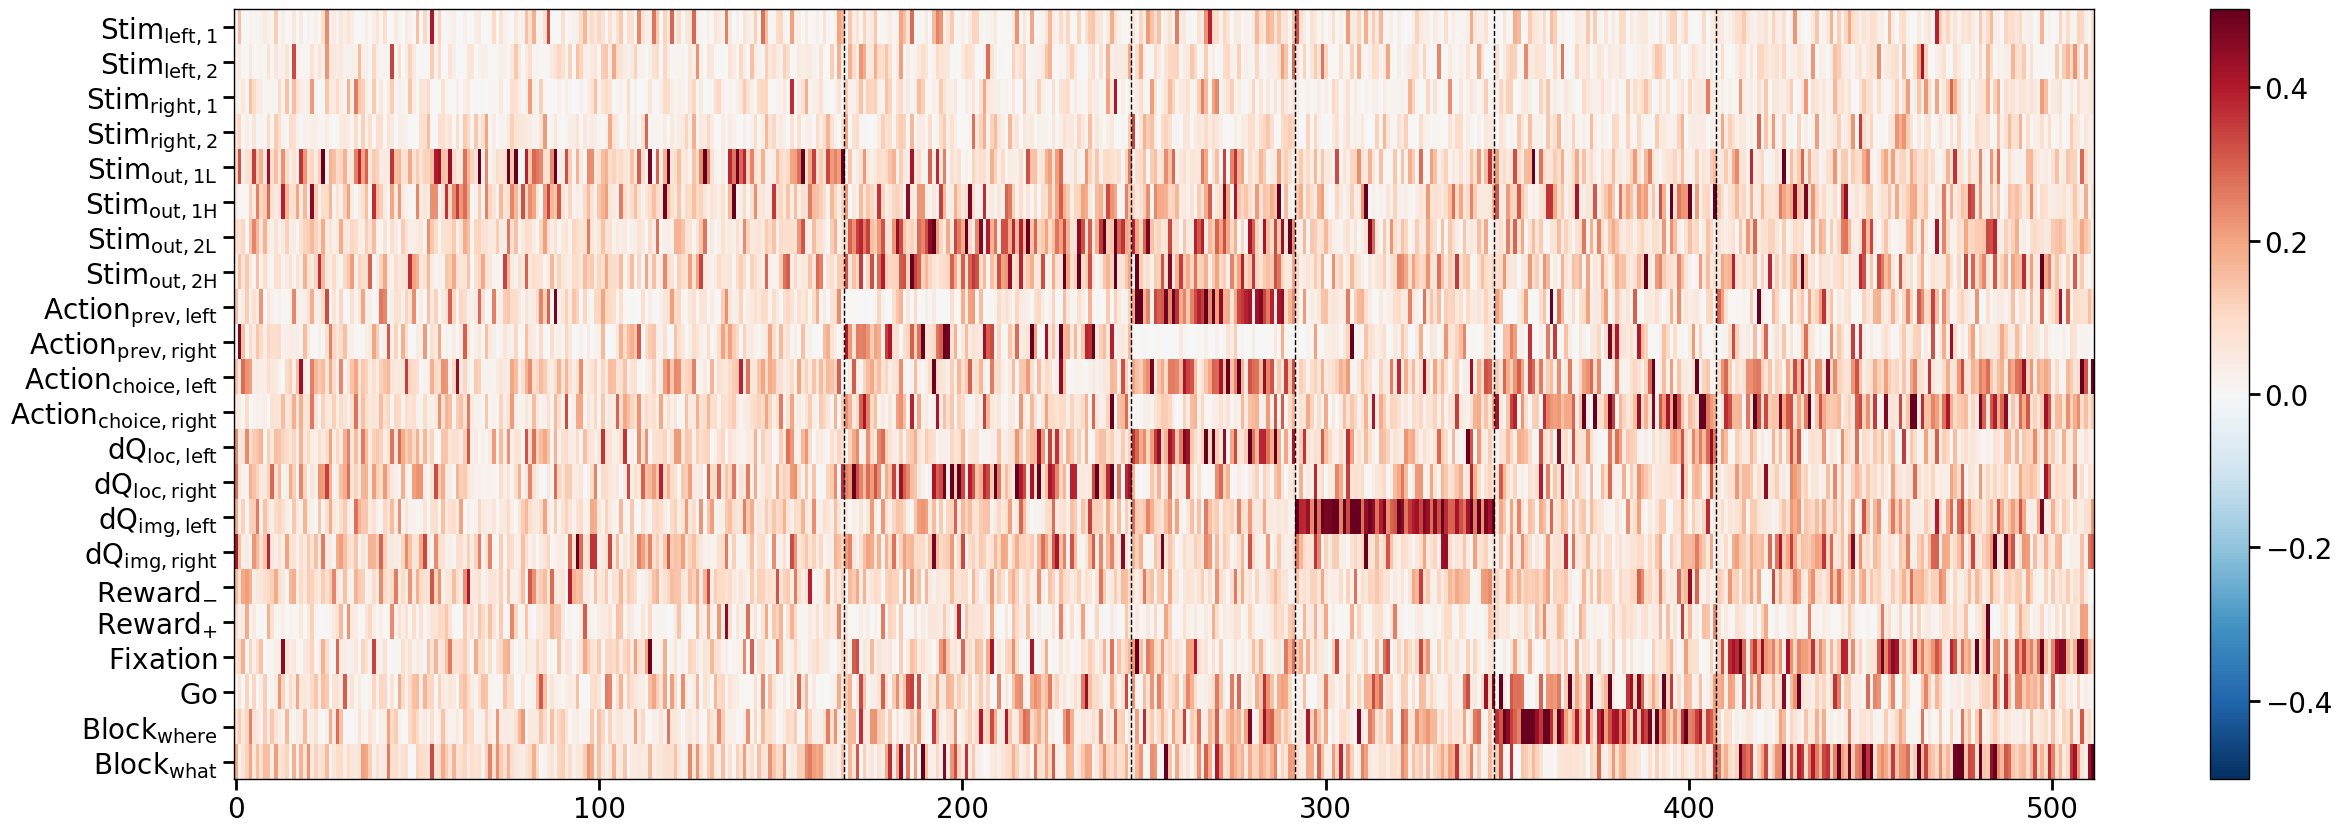

n_clusters=2, silhouette_score=0.376, min cluster size=52
n_clusters=3, one cluster has less than 1 units in a model


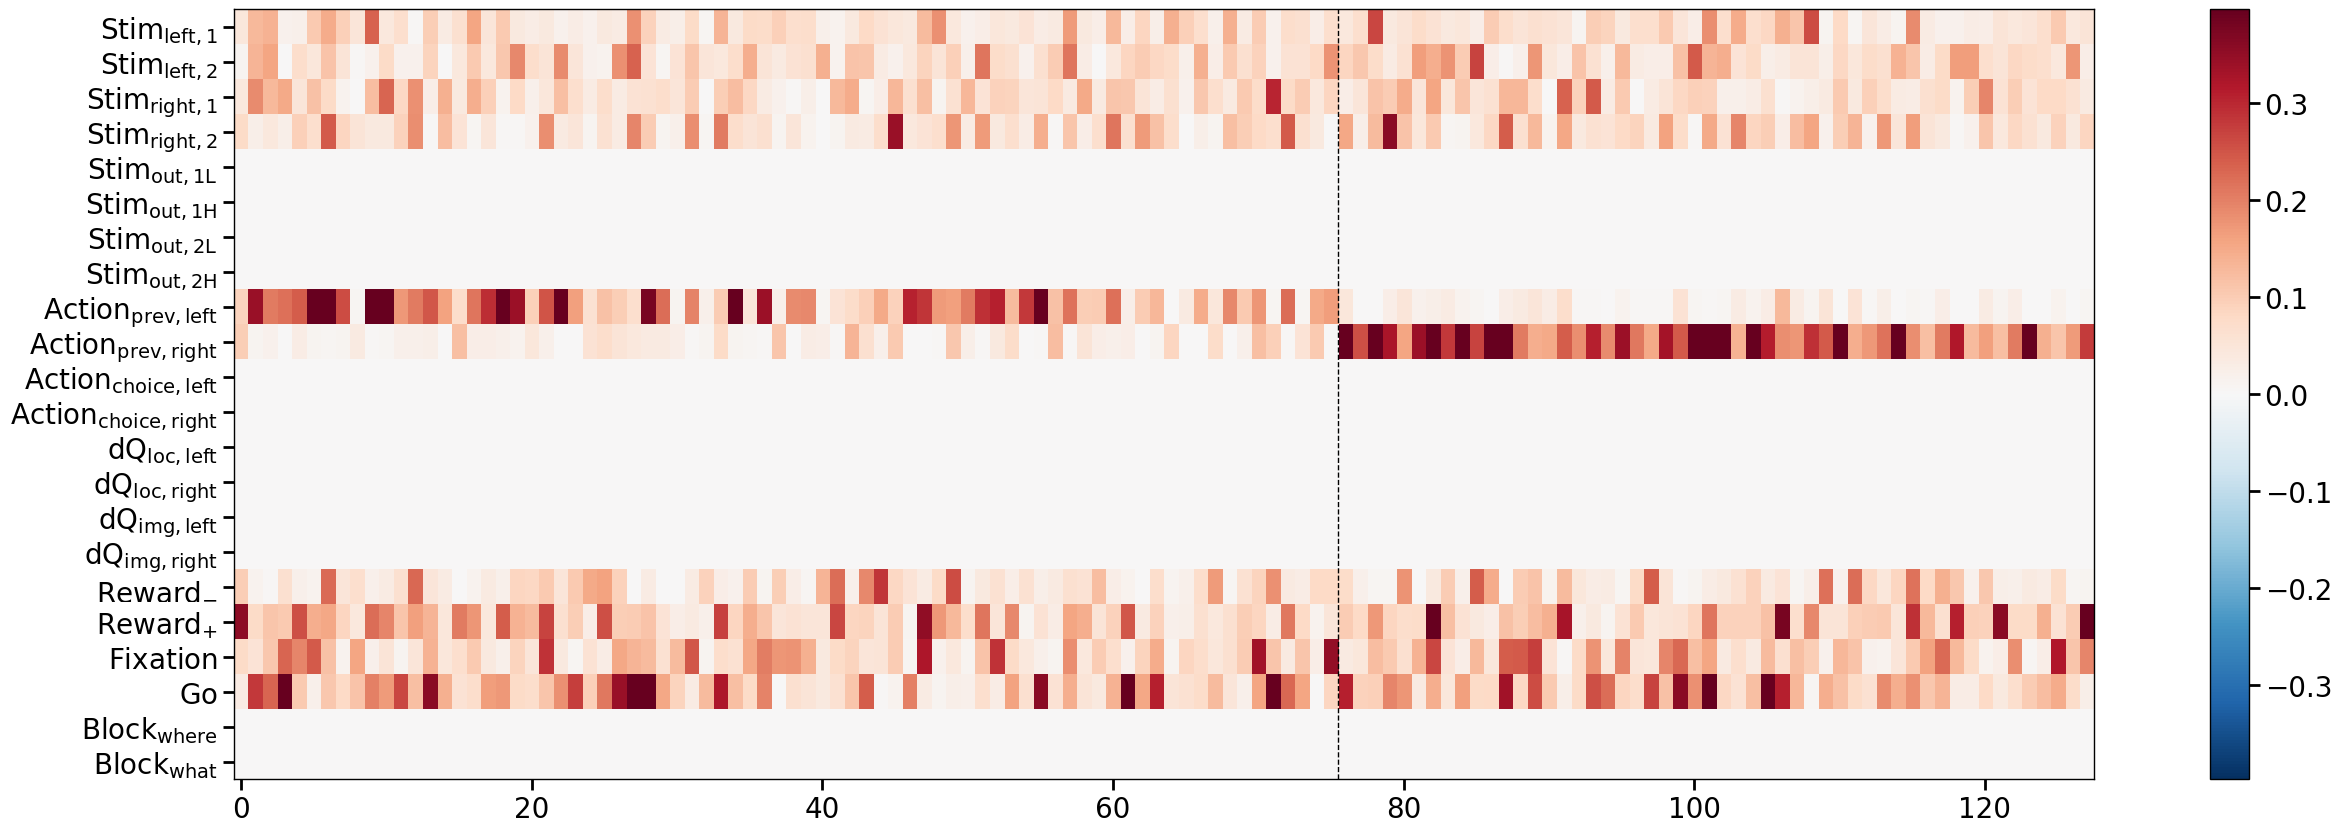

In [244]:
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score

all_model_clusters = []

def cluster_units(all_model_weights, ideal_n_clusters):
    # all_model_weights: shape (num_models, hidden_size, num_features)
    # Concatenate all hidden units from all models: (num_models * hidden_size, num_features)
    all_units = all_model_weights.reshape(-1, all_model_weights.shape[-1])

    silhouette_scores = []
    cluster_range = range(2, 16)  # Try 2 to 10 clusters

    for n_clusters in cluster_range:
        clustering = SpectralClustering(n_clusters=n_clusters, affinity='rbf', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
        labels = clustering.fit_predict(all_units)
        score = silhouette_score(all_units, labels, metric='cosine')
        _, clus_sizes = np.unique(labels, return_counts=True)
        silhouette_scores.append(score)
        labels = labels.reshape(all_model_weights.shape[:2])

        cluster_too_small = False
        min_clus_size = 1
        for clus_idx in range(n_clusters):
            if (np.sum(labels==clus_idx, axis=1) < min_clus_size).any():
                print(f"n_clusters={n_clusters}, one cluster has less than {min_clus_size} units in a model")
                cluster_too_small = True
                break
        if cluster_too_small:
            break
        print(f"n_clusters={n_clusters}, silhouette_score={score:.3f}, min cluster size={np.min(clus_sizes)}")
        
    clustering = SpectralClustering(n_clusters=ideal_n_clusters, affinity='rbf', assign_labels='kmeans', gamma=1/all_units.shape[-1], n_init=20)
    labels = clustering.fit_predict(all_units)

    # Calculate centroids
    centroids = np.stack([all_units[labels == k].mean(0) for k in range(ideal_n_clusters)], axis=0)

    label_sort_idx = np.argsort(np.argmax(centroids, axis=1))

    sorted_labels = np.zeros_like(labels)
    for i, k in enumerate(label_sort_idx):
        sorted_labels[labels == k] = i

    sorted_units = np.concatenate([all_units[labels == k] for k in label_sort_idx], axis=0)

    fig, ax = plt.subplots(figsize=(30, 10))
    clim = np.quantile(sorted_units.flatten(), 0.99)
    im = ax.imshow(sorted_units.T, aspect='auto', cmap='RdBu_r', norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmax=clim))

    ax.set_yticks(range(len(all_model_weight_names)), all_model_weight_names, rotation=0)

    label_counts = np.bincount(labels)[label_sort_idx]
    for bound in np.cumsum(label_counts)[:-1]:
        ax.axvline(bound-0.5, color='black', linestyle='--', lw=1)

    fig.colorbar(im)
    plt.show()

    return sorted_labels.reshape(all_model_weights.shape[:2])

ideal_exc_clusters = 6
all_model_exc_clusters = cluster_units(np.stack([weight[:E_SIZE] for weight in all_model_weights], axis=0), ideal_exc_clusters)

ideal_inh_clusters = 2
all_model_inh_clusters = cluster_units(np.stack([weight[E_SIZE:] for weight in all_model_weights], axis=0), ideal_inh_clusters)
all_model_clusters = np.concatenate([all_model_exc_clusters, all_model_inh_clusters+ideal_exc_clusters], axis=-1)



In [245]:
e_cluster_names = [r'$E_{left}$', r'$E_{right}$',r'$E_{NS}$',  r'$E_{where}$', r'$E_{what}$']
# e_cluster_names = [r'$E_{left_choice}$', r'$E_{null}$', r'$E_{right_choice}$', r'$E_{NS}$', r'$E_{where}$', r'$E_{what}$']
i_cluster_names = [r'$I_{what}$', r'$I_{where}$']


# Transformation of bases by recurrent weights

In [246]:
'''get all model's recurrent weights'''

all_model_recurrent_weights = []
for mdl in all_models:
    all_model_recurrent_weights.append(mdl.rnn.h2h.effective_weight().detach())
all_model_recurrent_weights = torch.stack(all_model_recurrent_weights, dim=0)  # (num_models, hidden_size, hidden_size)


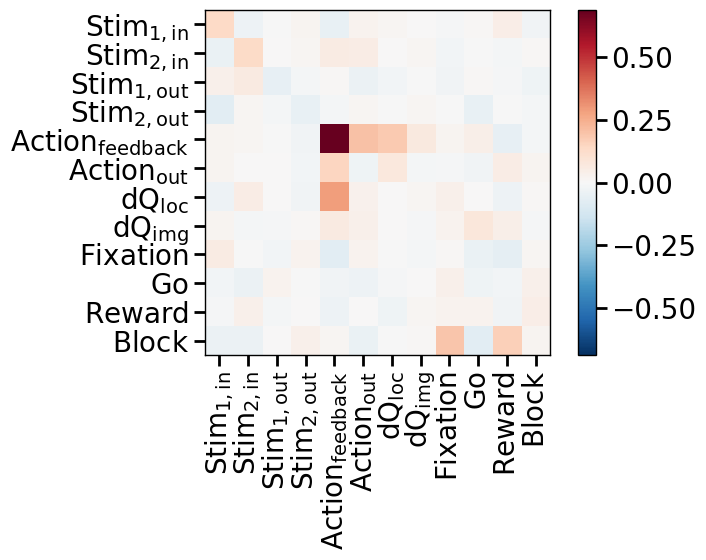

In [247]:
# Visualize how the recurrent weight transforms the input bases by performing a matrix change of variable
# For each model, transform the input bases by its recurrent weight, then average the resulting correlation matrices

num_models = all_model_recurrent_weights.shape[0]
num_bases = all_model_bases.shape[-1]

corrs = []
for i in range(num_models):
    W_rec = all_model_recurrent_weights[i].numpy()  # (hidden_size, hidden_size)
    input_bases = all_model_bases[i]  # (hidden_size, num_bases)
    transformed_bases = W_rec @ input_bases  # (hidden_size, num_bases)
    # transformed_bases = transformed_bases / np.linalg.norm(transformed_bases, axis=0, keepdims=True)
    corr = np.linalg.pinv(input_bases) @ transformed_bases # (num_bases, num_bases)
    corrs.append(corr)

mean_corr = np.mean(corrs, axis=0)
plt.figure(figsize=(8,6))
plt.imshow(mean_corr, cmap='RdBu_r', norm=mpl.colors.CenteredNorm(vcenter=0))
plt.colorbar()
plt.xticks(range(num_bases), all_bases_names, rotation=90)
plt.yticks(range(num_bases), all_bases_names)

plt.tight_layout()

plt.show()



ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (7).

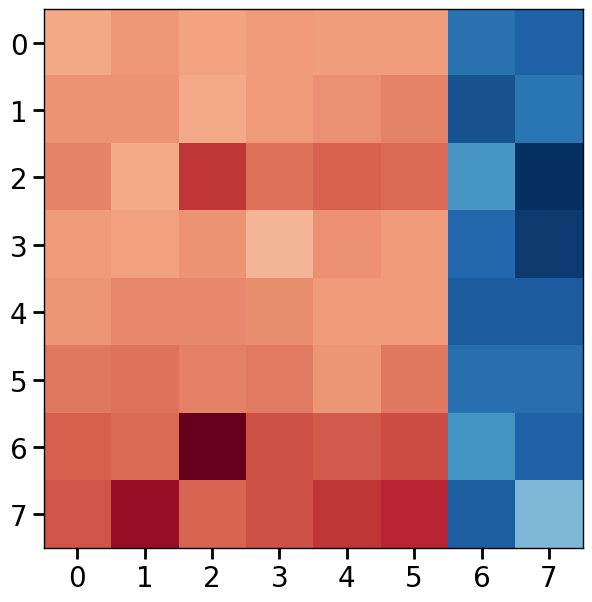

In [248]:
cluster_connections = []

for mdl_idx in range(all_model_weights.shape[0]):
    curr_mdl_cluster_connections = np.zeros((ideal_exc_clusters+ideal_inh_clusters, ideal_exc_clusters+ideal_inh_clusters))
    curr_mdl_exc_clusters = all_model_exc_clusters[mdl_idx]
    curr_mdl_inh_clusters = all_model_inh_clusters[mdl_idx]
    for i in range(ideal_exc_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i, j] = \
                all_model_recurrent_weights[mdl_idx,:E_SIZE,:E_SIZE][curr_mdl_exc_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_exc_clusters):
        for j in range(ideal_inh_clusters):
            curr_mdl_cluster_connections[i, j+ideal_exc_clusters] = \
                all_model_recurrent_weights[mdl_idx,:E_SIZE,E_SIZE:][curr_mdl_exc_clusters==i][:, curr_mdl_inh_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j] = \
                all_model_recurrent_weights[mdl_idx,E_SIZE:,:E_SIZE][curr_mdl_inh_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_inh_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j+ideal_exc_clusters] = \
                all_model_recurrent_weights[mdl_idx,E_SIZE:,E_SIZE:][curr_mdl_inh_clusters==i][:, curr_mdl_inh_clusters==j].mean()
    cluster_connections.append(curr_mdl_cluster_connections)

cluster_connections = np.array(cluster_connections)

plt.imshow(np.nanmean(cluster_connections, 0), cmap='RdBu_r', norm=mpl.colors.TwoSlopeNorm(vcenter=0))
plt.xticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names, rotation=60)
plt.yticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names)
plt.colorbar()

# Encoding and recall of the stim and action subspaces by plasticity

In [234]:
all_model_learning_rates = []
for mdl in all_models:
    all_model_learning_rates.append(mdl.plasticity.effective_lr().detach().numpy())
all_model_learning_rates = np.stack(all_model_learning_rates, axis=0)  # (num_models, hidden_size, hidden_size)

/scratch/f005d7d/ipykernel_1251725/1026272459.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_model_assoc_learning_rates[mdl_idx, i, j] = recall


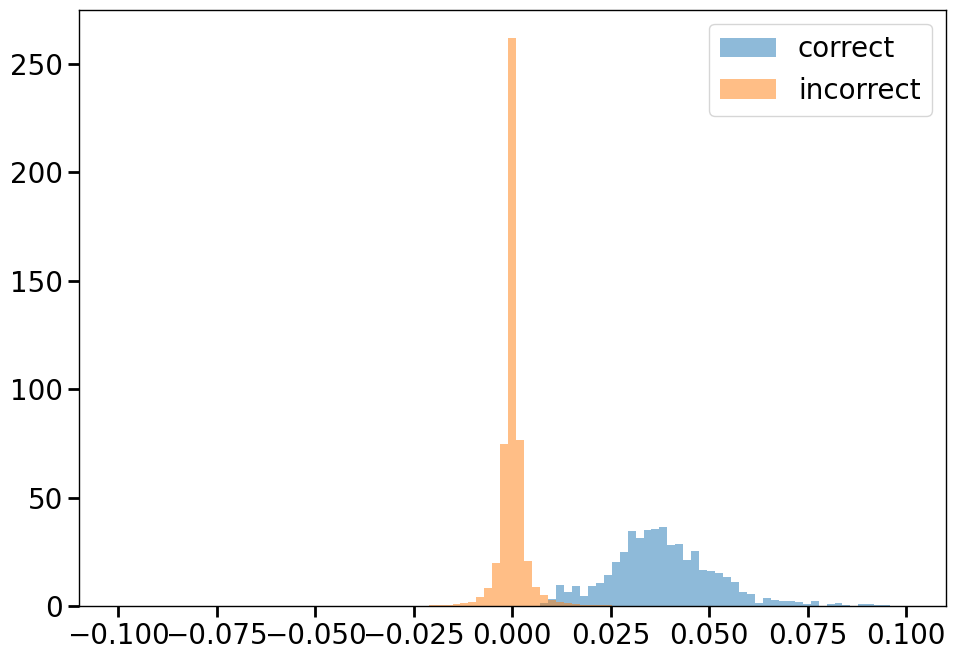

In [235]:
from itertools import product

all_model_recall_correct = []
all_model_recall_incorrect = []

all_model_assoc_learning_rates = np.nan*np.empty((all_model_bases.shape[0], all_model_bases.shape[-1], all_model_bases.shape[-1]))

for mdl_idx in range(all_model_bases.shape[0]):
    for (i, j, k, l) in product(range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1]), range(all_model_bases.shape[-1])):
        mem = all_model_bases[mdl_idx,:,i][:, None]*all_model_learning_rates[mdl_idx]*all_model_bases[mdl_idx,:,j][None] # (hidden_size, 1) * (hidden_size, hidden_size) * (1, hidden_size) = (hidden_size, hidden_size)
        recall = all_model_bases[mdl_idx,:,k][None]@mem@all_model_bases[mdl_idx,:,l][:,None] # (1, hidden_size) @ (hidden_size, hidden_size) @ (hidden_size, 1) = (1, 1)

        if i==k and j==l:
            all_model_recall_correct.append(recall)
            all_model_assoc_learning_rates[mdl_idx, i, j] = recall
        else:
            all_model_recall_incorrect.append(recall)

all_model_recall_correct = np.array(all_model_recall_correct)   
all_model_recall_incorrect = np.array(all_model_recall_incorrect)

plt.hist(all_model_recall_correct.flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='correct', density=True)
plt.hist(all_model_recall_incorrect.flatten(), bins=np.linspace(-0.1, 0.1, 100), alpha=0.5, label='incorrect', density=True)
plt.legend()
plt.tight_layout()
plt.show()

    

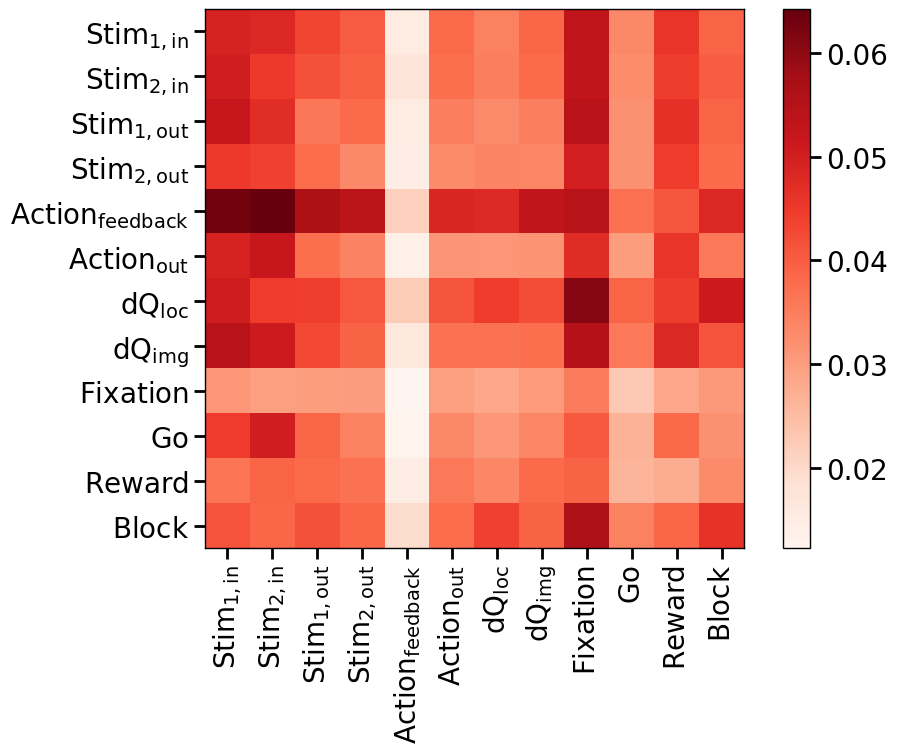

In [236]:
plt.imshow(all_model_assoc_learning_rates.mean(0)*(all_model_assoc_learning_rates.mean(0)>0), cmap='Reds')
plt.xticks(range(all_model_bases.shape[-1]), all_bases_names, rotation=90)
plt.yticks(range(all_model_bases.shape[-1]), all_bases_names)
plt.colorbar()

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (5).

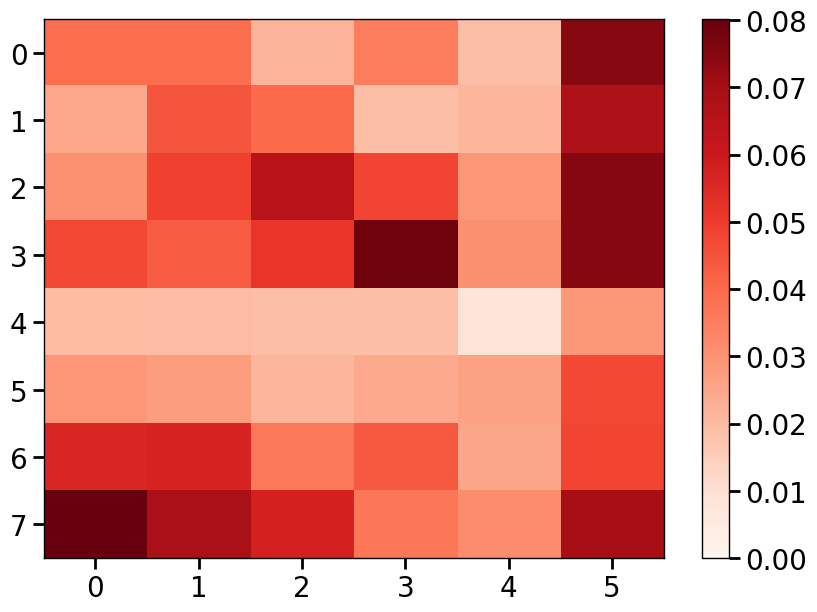

In [237]:
cluster_connections = []

for mdl_idx in range(all_model_learning_rates.shape[0]):
    curr_mdl_cluster_connections = np.zeros((ideal_exc_clusters+ideal_inh_clusters, ideal_exc_clusters))
    curr_mdl_exc_clusters = all_model_exc_clusters[mdl_idx]
    curr_mdl_inh_clusters = all_model_inh_clusters[mdl_idx]
    for i in range(ideal_exc_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i, j] = \
                all_model_learning_rates[mdl_idx,:E_SIZE,:E_SIZE][curr_mdl_exc_clusters==i][:, curr_mdl_exc_clusters==j].mean()
    for i in range(ideal_inh_clusters):
        for j in range(ideal_exc_clusters):
            curr_mdl_cluster_connections[i+ideal_exc_clusters, j] = \
                all_model_learning_rates[mdl_idx,E_SIZE:,:E_SIZE][curr_mdl_inh_clusters==i][:, curr_mdl_exc_clusters==j].mean()

    cluster_connections.append(curr_mdl_cluster_connections)

cluster_connections = np.array(cluster_connections)

plt.imshow(cluster_connections.mean(0), cmap='Reds', vmin=0,aspect='auto')
plt.colorbar()
plt.xticks(range(ideal_exc_clusters), e_cluster_names, rotation=30)
plt.yticks(range(ideal_exc_clusters+ideal_inh_clusters), e_cluster_names+i_cluster_names)


# Subspace-based analyses of simulated firing rates

In [85]:
print(mdl_bases.shape)
mdl_neuron_states.shape

(80, 9)


(100, 80, 90, 80)

In [86]:
neuron_state_proj = np.empty((*all_saved_states['neuron_states'].shape[:3], all_model_bases.shape[-1]))

for mdl_idx, mdl_bases in enumerate(all_model_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_neuron_states = np.tanh(np.maximum(all_saved_states['neuron_states'][mdl_mask].squeeze(), 0))
    
    # mdl_neuron_states -= mdl_neuron_states.mean(0, keepdims=True)
    
    neuron_state_proj[mdl_mask] = (mdl_neuron_states[...,None]*mdl_bases[None,None,None]).sum(-2)
    
neuron_state_proj = np.stack(neuron_state_proj)

0
1
2
3
4
5
6
7


In [87]:
neuron_state_proj.shape

(800, 80, 90, 9)

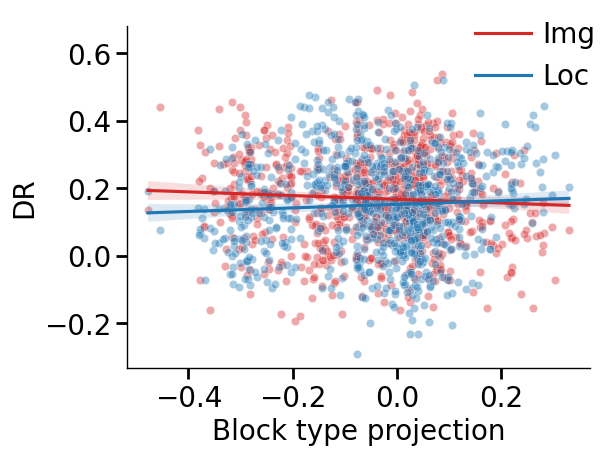

In [88]:
neuron_block_type_proj = neuron_state_proj.mean((1,2))[...,-1]
dr_loc = all_block_stay_probs[:,2]-all_block_stay_probs[:,0]
dr_img = all_block_stay_probs[:,3]-all_block_stay_probs[:,1]

fig, ax = plt.subplots(1,1,figsize=(6.4, 4.8))

sns.scatterplot(x=neuron_block_type_proj, y=dr_img, color='tab:red', ax=ax, alpha=0.4, legend=False)
sns.scatterplot(x=neuron_block_type_proj, y=dr_loc, color='tab:blue', ax=ax, alpha=0.4, legend=False)

sns.regplot(x=neuron_block_type_proj, y=dr_img, truncate=True, color='tab:red', 
            scatter=False, label='Img', ax=ax)
sns.regplot(x=neuron_block_type_proj, y=dr_loc, truncate=True, color='tab:blue', 
            scatter=False, label='Loc', ax=ax)


ax.set_xlabel('Block type projection')
ax.set_ylabel('DR')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.1)

sns.despine()

fig.legend(loc='upper right', bbox_to_anchor=(1., 1.0), handletextpad=0.4, frameon=False)
fig.tight_layout()

# plt.savefig(os.path.join(figure_data_dir, "RNN_blk_typ_proj_dr_corr.pdf"), bbox_inches='tight')




In [89]:
neuron_block_type_proj.shape

(800,)

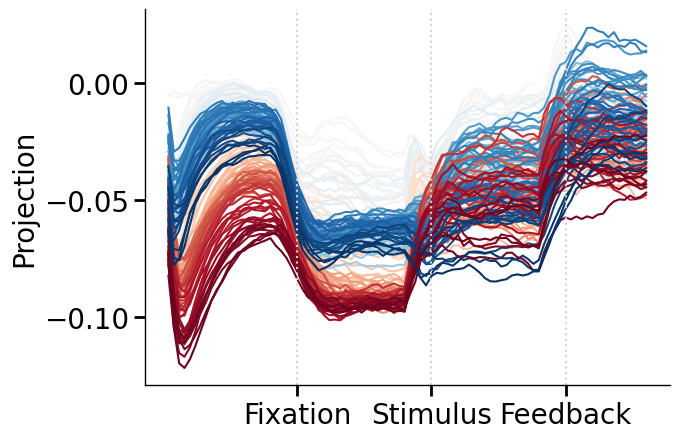

In [90]:
def plot_block_type_projection(ax, neuron_state_proj, all_saved_states, dim_to_plot=-1):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    for trial_idx in range(neuron_state_proj.shape[1]):
        ax.plot((neuron_state_proj[where_blk_mask,trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials-trial_idx])
        ax.plot((neuron_state_proj[~where_blk_mask,trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials+trial_idx])
        
    phase_times = np.cumsum([what_where_task.times['ITI'],
                    what_where_task.times['fixation_time'],
                    what_where_task.times['stim_time']])/what_where_task.dt-1
    
    ax.set_xticks(phase_times)
    ax.set_xticklabels(['Fixation', 'Stimulus', 'Feedback'])
    
    for phase_time in phase_times:
        ax.axvline(x=phase_time, c='lightgrey', ls=':')
    
fig, axes = plt.subplots(1, 1, figsize=(7.2, 4.8))
    
plot_block_type_projection(axes, neuron_state_proj, all_saved_states)

axes.set_ylabel('Projection')
# axes.set_xlabel('Timesteps')

sns.despine()

fig.tight_layout()


# plt.savefig(os.path.join(figure_data_dir, "RNN_blk_typ_proj_by_time.pdf"), bbox_inches='tight')


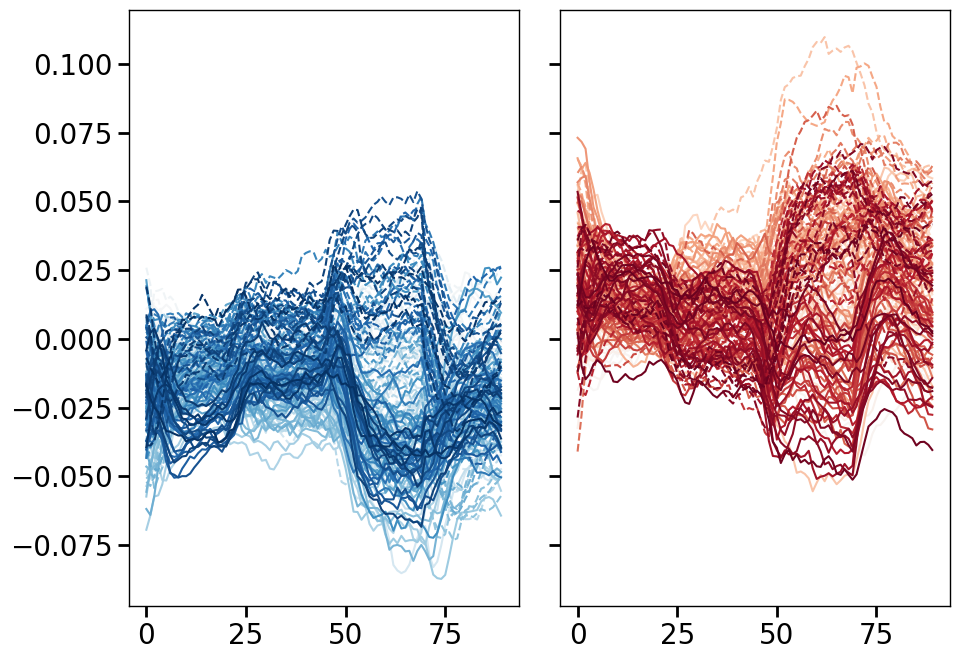

In [72]:
def plot_projection_by_blk_type(neuron_state_proj, all_saved_states, dim_to_plot, var_key_name):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
    
    var_mask = (all_saved_states[var_key_name]==0).squeeze()
    
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    for trial_idx in range(neuron_state_proj.shape[1]):
    
        axes[0].plot((neuron_state_proj[where_blk_mask&var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials-trial_idx], ls='--')
        axes[0].plot((neuron_state_proj[where_blk_mask&~var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials-trial_idx])
    

        axes[1].plot((neuron_state_proj[~where_blk_mask&var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials+trial_idx], ls='--')
        axes[1].plot((neuron_state_proj[~where_blk_mask&~var_mask[:,trial_idx],trial_idx,:,dim_to_plot]).mean((0)).T,
                    c=colors[num_trials+trial_idx])
    
    fig.tight_layout()
    
    plt.show()
    
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 4, 'loc_chosen')
    
    

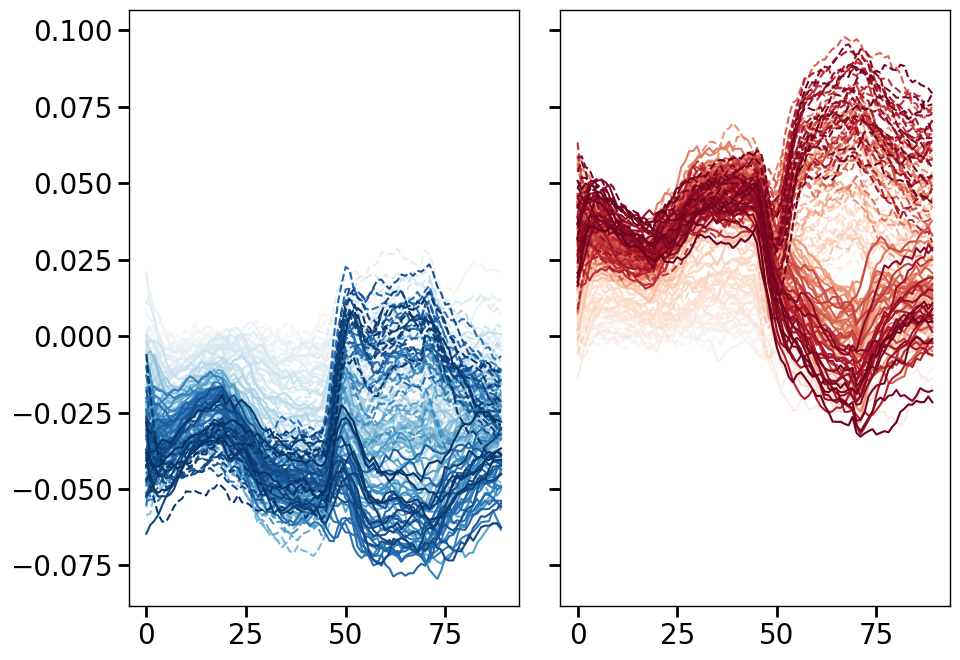

In [81]:
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 5, 'loc_chosen')

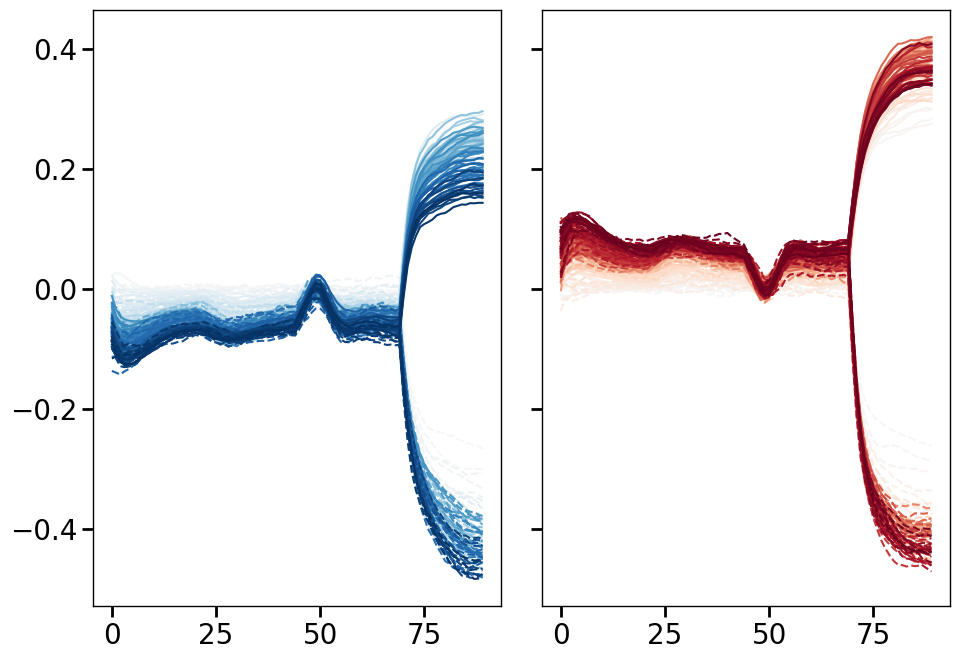

In [31]:
plot_projection_by_blk_type(neuron_state_proj, all_saved_states, 7, 'reward')

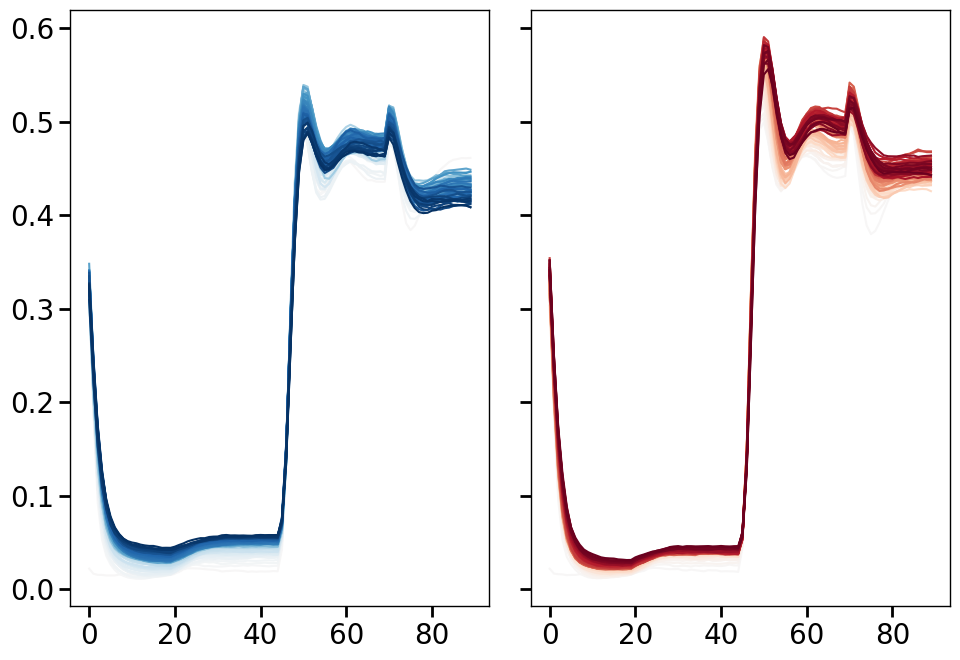

In [32]:
def plot_abs_proj_by_blk_type(neuron_state_proj, all_saved_states, dims_to_plot):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = neuron_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
        
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    
    for trial_idx in range(neuron_state_proj.shape[1]):
    
        axes[0].plot(np.abs(neuron_state_proj[where_blk_mask,trial_idx][...,dims_to_plot]).mean((0,-1)).T,
                    c=colors[num_trials-trial_idx]);
        axes[1].plot(np.abs(neuron_state_proj[~where_blk_mask,trial_idx][...,dims_to_plot]).mean((0,-1)).T,
                    c=colors[num_trials+trial_idx]);
    
    fig.tight_layout()
    
    plt.show()
    
plot_abs_proj_by_blk_type(neuron_state_proj, all_saved_states, [0,1])
    
    

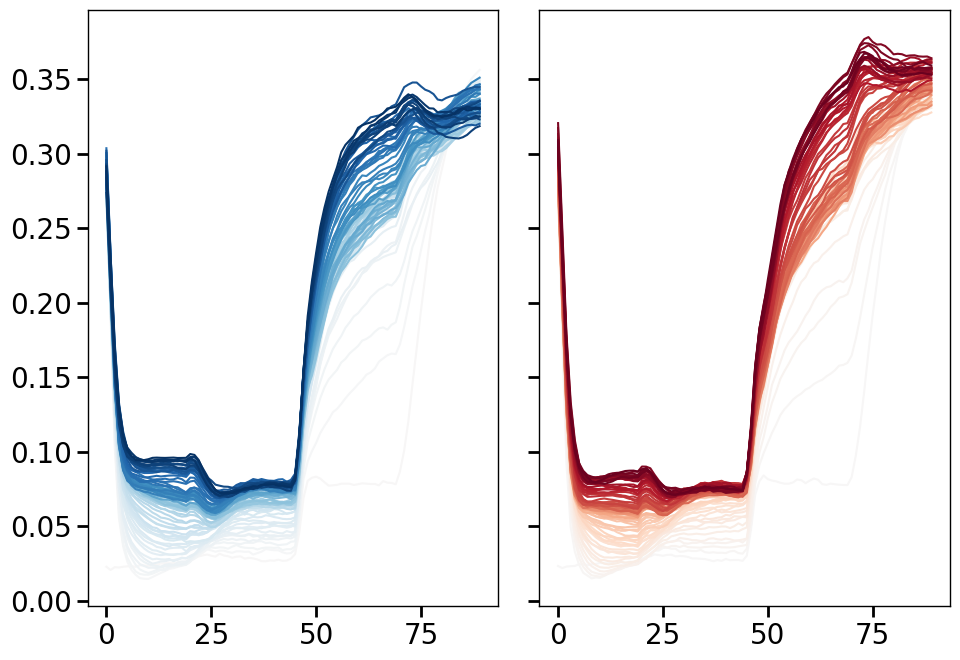

In [33]:
plot_abs_proj_by_blk_type(neuron_state_proj, all_saved_states, [2,3])


## Dimension specific results

In [34]:
neuron_state_proj_dim_readout = np.empty((*all_saved_states['neuron_states'].shape[:3], all_model_dim_readout_bases.shape[-1]))

for mdl_idx, mdl_bases in enumerate(all_model_dim_readout_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_neuron_states = np.tanh(np.maximum(all_saved_states['neuron_states'][mdl_mask].squeeze(), 0))
    
    mdl_neuron_states -= mdl_neuron_states.mean(0, keepdims=True)
    
    neuron_state_proj_dim_readout[mdl_mask] = (mdl_neuron_states[...,None]*mdl_bases[None,None,None]).sum(-2)
    
neuron_state_proj_dim_readout = np.stack(neuron_state_proj_dim_readout)


0
1
2
3
4
5
6
7


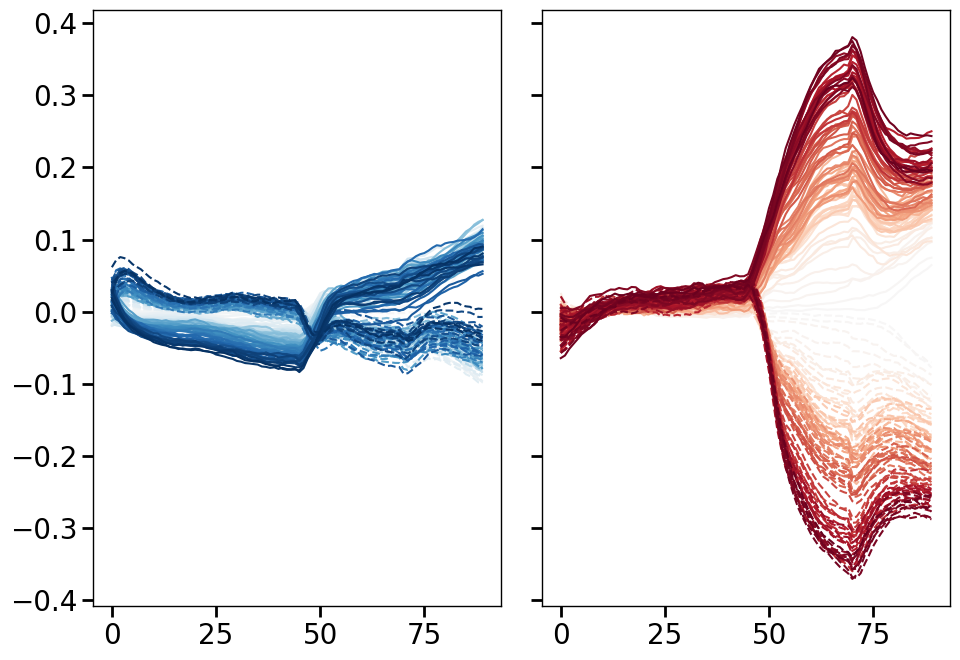

In [35]:
plot_projection_by_blk_type(neuron_state_proj_dim_readout, all_saved_states, 3, 'loc_chosen')


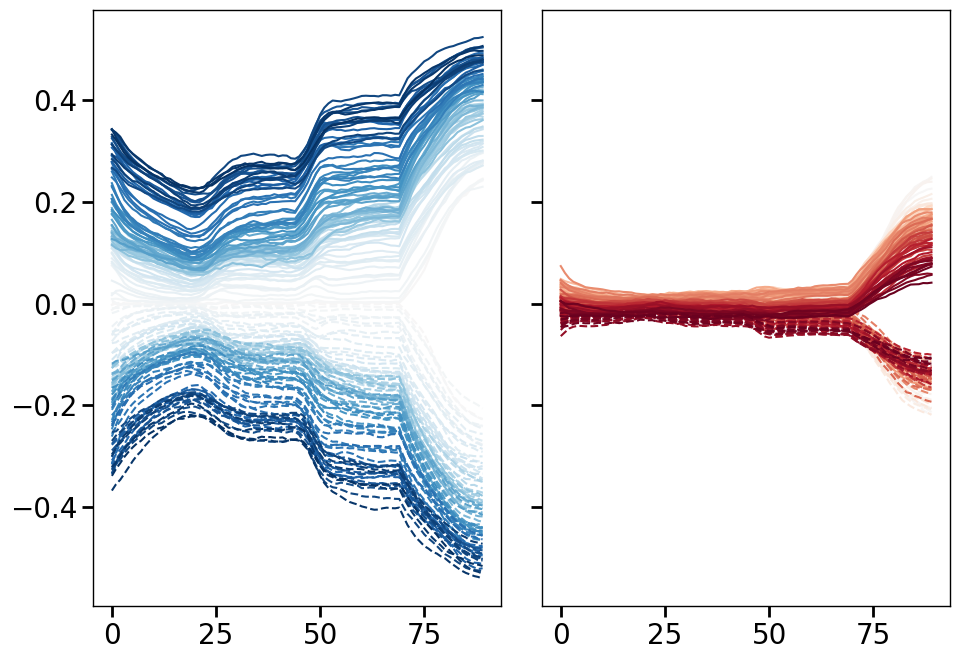

In [37]:
plot_projection_by_blk_type(neuron_state_proj_dim_readout, all_saved_states, 2, 'loc_chosen')


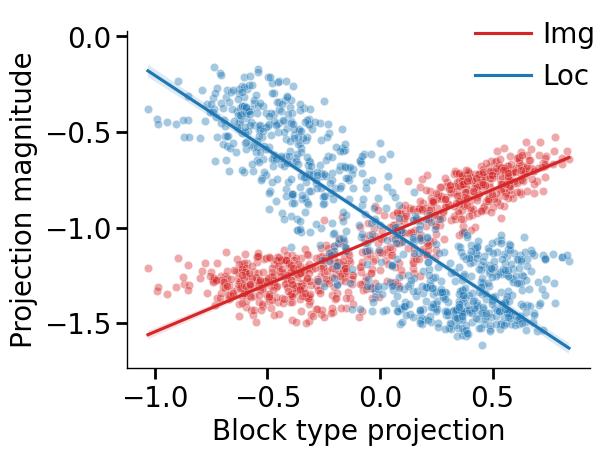

In [50]:
abs_proj_loc = np.abs(neuron_state_proj_dim_readout)[...,2].mean((1,2))
abs_proj_img = np.abs(neuron_state_proj_dim_readout)[...,3].mean((1,2))

fig, ax = plt.subplots(1,1,figsize=(6.4, 4.8))

sns.scatterplot(x=neuron_block_type_proj, y=np.log10(abs_proj_img), 
                color='tab:red', ax=ax, alpha=0.4, legend=False)
sns.scatterplot(x=neuron_block_type_proj, y=np.log10(abs_proj_loc), 
                color='tab:blue', ax=ax, alpha=0.4, legend=False)

sns.regplot(x=neuron_block_type_proj, y=np.log10(abs_proj_img), truncate=True, color='tab:red', 
            scatter=False, label='Img', ax=ax)
sns.regplot(x=neuron_block_type_proj, y=np.log10(abs_proj_loc), truncate=True, color='tab:blue', 
            scatter=False, label='Loc', ax=ax)


ax.set_xlabel('Block type projection')
ax.set_ylabel('Projection magnitude')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.1)

sns.despine()

fig.legend(loc='upper right', bbox_to_anchor=(1., 1.0), handletextpad=0.4, frameon=False)
fig.tight_layout()

# Clustering-based analyses of simulations

In [51]:
neuron_cluster_activity = np.empty((*all_saved_states['neuron_states'].shape[:3], ideal_exc_clusters+ideal_inh_clusters))
neuron_cluster_gains = np.empty((*all_saved_states['neuron_states'].shape[:3], ideal_exc_clusters+ideal_inh_clusters))

# calculate the average firing rate and gain of each cluster
for mdl_idx, mdl_bases in enumerate(all_model_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_neuron_states = all_saved_states['neuron_states'][mdl_mask].squeeze()
    mdl_neuron_firing_rates = np.tanh(np.maximum(mdl_neuron_states, 0))
    mdl_neuron_gains = (1-np.tanh(mdl_neuron_states)**2)*(mdl_neuron_states>0)
    for cluster_idx in range(ideal_exc_clusters+ideal_inh_clusters):
        neuron_cluster_activity[mdl_mask,...,cluster_idx] = (mdl_neuron_firing_rates[...,all_model_clusters[mdl_idx]==cluster_idx]).mean(-1)
        neuron_cluster_gains[mdl_mask,...,cluster_idx] = (mdl_neuron_gains[...,all_model_clusters[mdl_idx]==cluster_idx]).mean(-1)
    
neuron_cluster_activity = np.stack(neuron_cluster_activity) # (num_blocks, num_trials, num_timesteps, num_clusters)
neuron_cluster_gains = np.stack(neuron_cluster_gains) # (num_blocks, num_trials, num_timesteps, num_clusters)



0
1
2
3
4
5
6
7


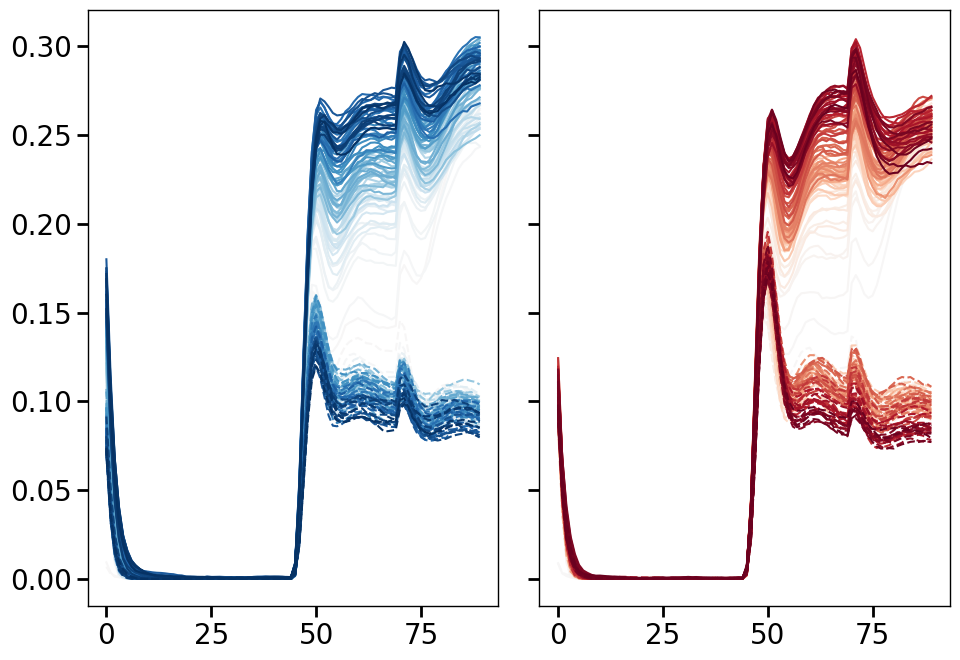

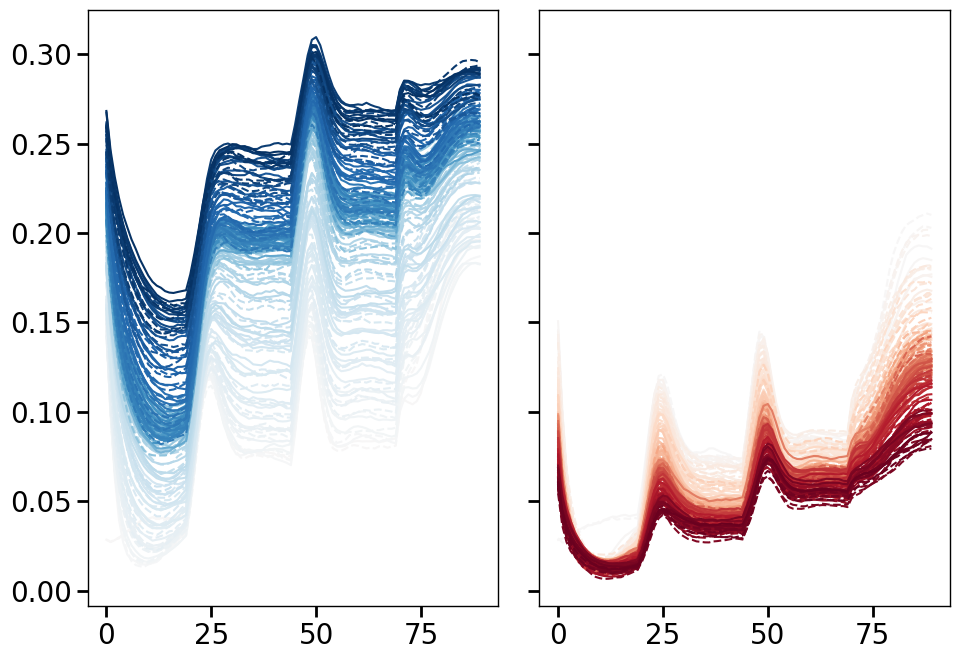

In [52]:
plot_projection_by_blk_type(neuron_cluster_activity, all_saved_states, 2, 'loc_chosen')
plot_projection_by_blk_type(neuron_cluster_activity, all_saved_states, 3, 'loc_chosen')

# plot_block_type_projection(neuron_cluster_gains, all_saved_states, dim_to_plot=0)

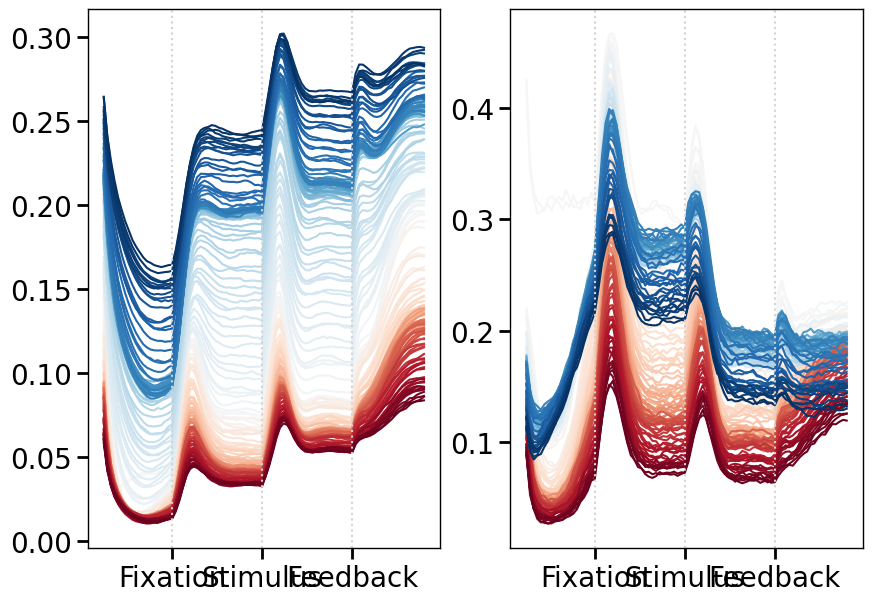

In [53]:
fig, axes = plt.subplots(1,2)

plot_block_type_projection(axes[0], neuron_cluster_activity, all_saved_states, dim_to_plot=3)
plot_block_type_projection(axes[1], neuron_cluster_gains, all_saved_states, dim_to_plot=3)

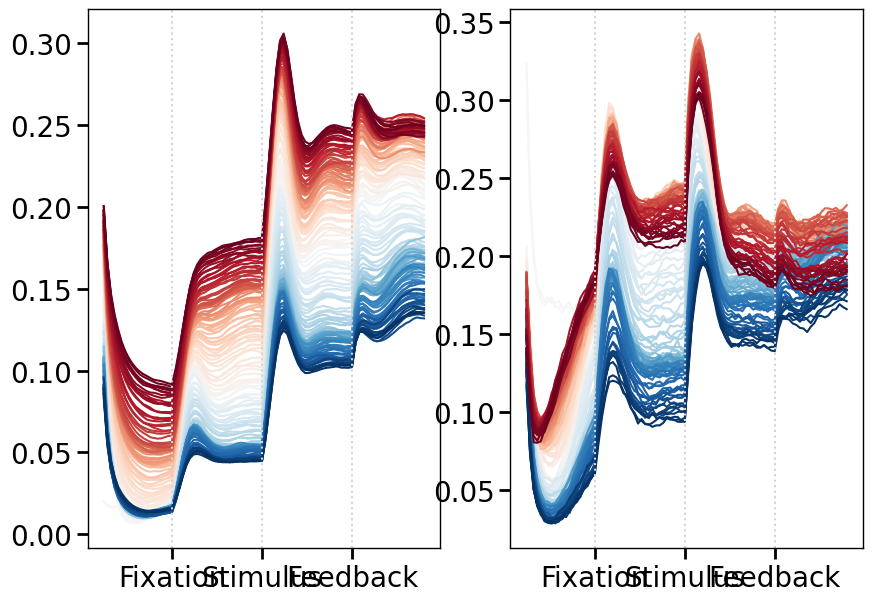

In [54]:
fig, axes = plt.subplots(1,2)

plot_block_type_projection(axes[0], neuron_cluster_activity, all_saved_states, dim_to_plot=4)
plot_block_type_projection(axes[1], neuron_cluster_gains, all_saved_states, dim_to_plot=4)

# Subspace-based analyses of simulated synaptic weights


$Routing = dO/dV = \vec{o}^\top J \vec{v}_{dim} = \vec{o}^\top ((1-\alpha)I+\alpha W\sigma') \vec{v}$

In [55]:
synaptic_state_proj = np.empty((*all_saved_states['synaptic_states'].shape[:2], \
                                all_model_bases.shape[-1], all_model_bases.shape[-1]))

for mdl_idx, mdl_bases in enumerate(all_model_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_synaptic_states = all_models[mdl_idx].rnn.h2h.effective_weight(torch.from_numpy(all_saved_states['synaptic_states'][mdl_mask].squeeze())).numpy()
    synaptic_state_proj[mdl_mask] = (mdl_bases.T[None,None]@mdl_synaptic_states@mdl_bases[None,None])
    
synaptic_state_proj = np.stack(synaptic_state_proj)
synaptic_state_proj -= synaptic_state_proj[:,0:1]

0
1
2
3
4
5
6
7


In [58]:
all_model_gains = (all_saved_states['neuron_states']>0)*(1-np.tanh(all_saved_states['neuron_states'])**2)

In [143]:
synaptic_state_proj_dim_readout = np.empty((*all_saved_states['synaptic_states'].shape[:2], 2, 2))

for mdl_idx, mdl_bases in enumerate(all_model_dim_readout_bases):
    print(mdl_idx)
    mdl_mask = all_saved_states['model_index']==mdl_idx
    mdl_synaptic_states = all_models[mdl_idx].rnn.h2h.effective_weight(torch.from_numpy(all_saved_states['synaptic_states'][mdl_mask].squeeze())).numpy()
    mdl_synaptic_states = mdl_synaptic_states*all_model_gains[mdl_mask].mean(2)
    synaptic_state_proj_dim_readout[mdl_mask] = (mdl_bases[...,[0,1]].T[None,None]@mdl_synaptic_states@mdl_bases[...,[2,3]][None,None])
    
synaptic_state_proj_dim_readout = np.stack(synaptic_state_proj_dim_readout)
# synaptic_state_proj_dim_readout -= synaptic_state_proj_dim_readout[:,0:1]

0
1
2
3
4
5
6
7


In [144]:
synaptic_state_proj_dim_readout.shape

(800, 80, 2, 2)

In [145]:
def plot_absolute_dW_by_blk_type(synaptic_state_proj, all_saved_states, entry_to_plot, var_key_name):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = synaptic_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
    
    var_mask = (all_saved_states[var_key_name]==0).squeeze()
    
    cmap = mpl.colormaps['RdBu_r']
    colors = cmap(np.linspace(0, 1, 2*num_trials+1))
    
    synaptic_state_proj_by_condition = np.empty((2,num_trials))
        
    for trial_idx in range(synaptic_state_proj.shape[1]):
        synaptic_state_proj_by_condition[0,trial_idx] = np.abs(synaptic_state_proj[where_blk_mask,trial_idx][...,entry_to_plot[0],entry_to_plot[1]]).mean(0)
        synaptic_state_proj_by_condition[1,trial_idx] = np.abs(synaptic_state_proj[~where_blk_mask,trial_idx][...,entry_to_plot[0],entry_to_plot[1]]).mean(0)
        
    axes[0].plot(synaptic_state_proj_by_condition[1],
                c='tab:blue')
    axes[1].plot(synaptic_state_proj_by_condition[0],
                c='tab:red')
    
    fig.tight_layout()
    
    plt.show()

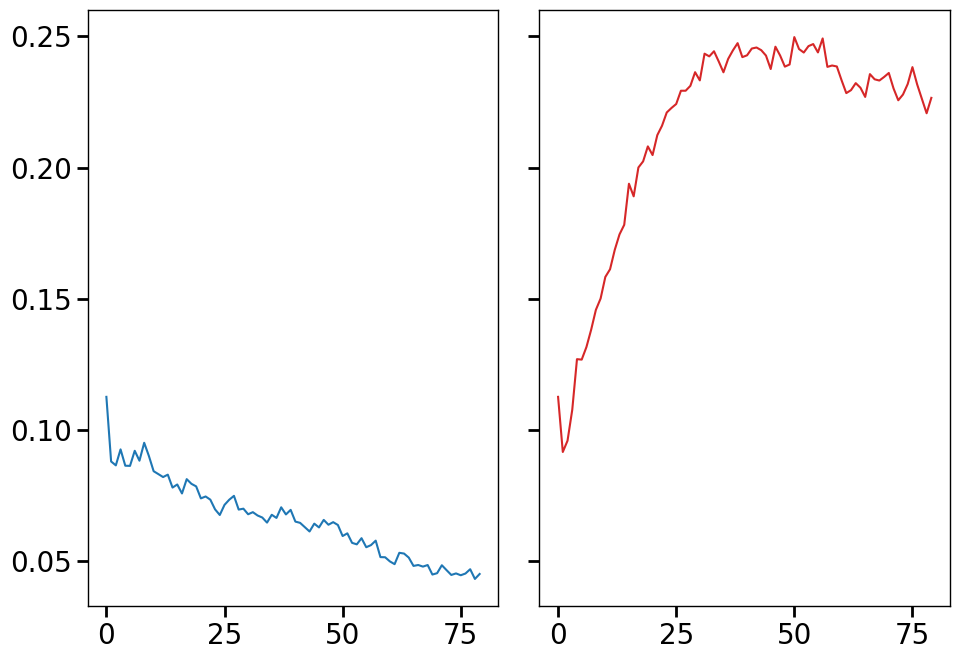

In [146]:
plot_absolute_dW_by_blk_type(synaptic_state_proj_dim_readout, all_saved_states, [1,0], 'loc_chosen')


In [147]:
synaptic_state_proj_dim_readout.shape

(800, 80, 2, 2)

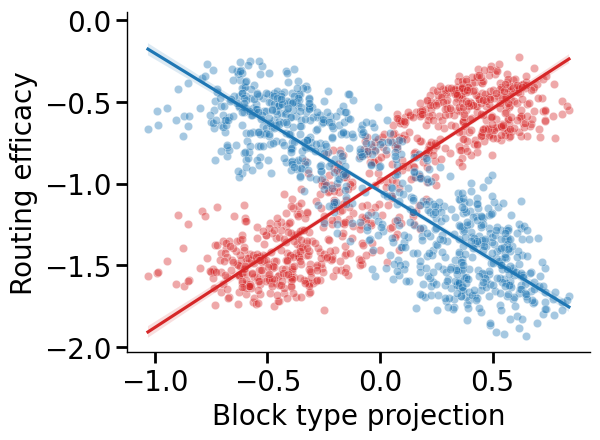

In [150]:
abs_proj_loc = np.abs(synaptic_state_proj_dim_readout)[...,1,0].mean(1)
abs_proj_img = np.abs(synaptic_state_proj_dim_readout)[...,1,1].mean(1)

fig, ax = plt.subplots(1,1,figsize=(6.4, 4.8))

sns.scatterplot(x=neuron_block_type_proj, y=np.log10(abs_proj_img), 
                color='tab:red', ax=ax, alpha=0.4, legend=False)
sns.scatterplot(x=neuron_block_type_proj, y=np.log10(abs_proj_loc), 
                color='tab:blue', ax=ax, alpha=0.4, legend=False)

sns.regplot(x=neuron_block_type_proj, y=np.log10(abs_proj_img), truncate=True, color='tab:red', 
            scatter=False, label='Img', ax=ax)
sns.regplot(x=neuron_block_type_proj, y=np.log10(abs_proj_loc), truncate=True, color='tab:blue', 
            scatter=False, label='Loc', ax=ax)


ax.set_xlabel('Block type projection')
ax.set_ylabel('Routing efficacy')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.1)

sns.despine()

# fig.legend(loc='upper center',  handletextpad=0.4, frameon=False)
fig.tight_layout()

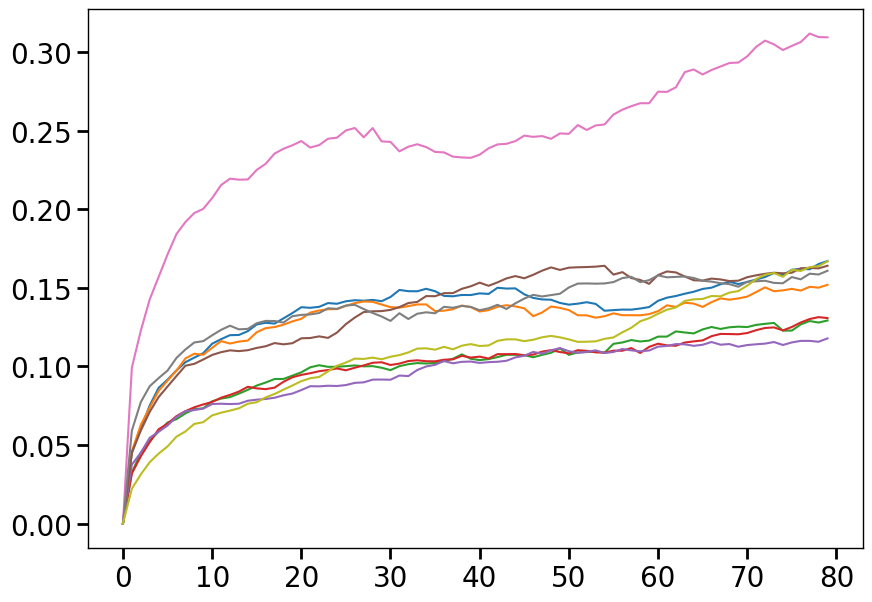

In [74]:
plt.plot(np.abs(synaptic_state_proj[:,:,4,:]).mean(0));


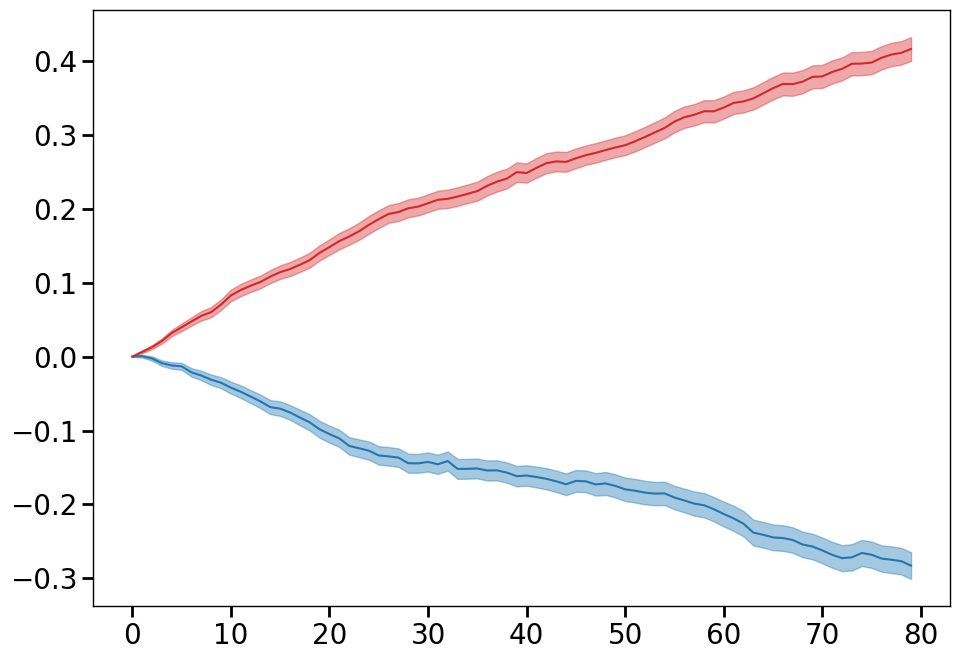

In [75]:
def plot_block_type_dW(synaptic_state_proj, all_saved_states, entry_to_plot=(8,6)):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = synaptic_state_proj.shape[1]
        
    proj_mean = (synaptic_state_proj[where_blk_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    stderr = (synaptic_state_proj[where_blk_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(where_blk_mask))
    plt.plot(proj_mean, c='tab:blue')
    plt.fill_between(np.arange(num_trials), proj_mean-stderr, proj_mean+stderr, color='tab:blue', alpha=0.4)
    proj_mean = (synaptic_state_proj[~where_blk_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    stderr = (synaptic_state_proj[~where_blk_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(~where_blk_mask))
    plt.plot(proj_mean, c='tab:red')
    plt.fill_between(np.arange(num_trials), proj_mean-stderr, proj_mean+stderr, color='tab:red', alpha=0.4)
        
    plt.tight_layout()
    
    plt.show()
    
plot_block_type_dW(synaptic_state_proj, all_saved_states)
    

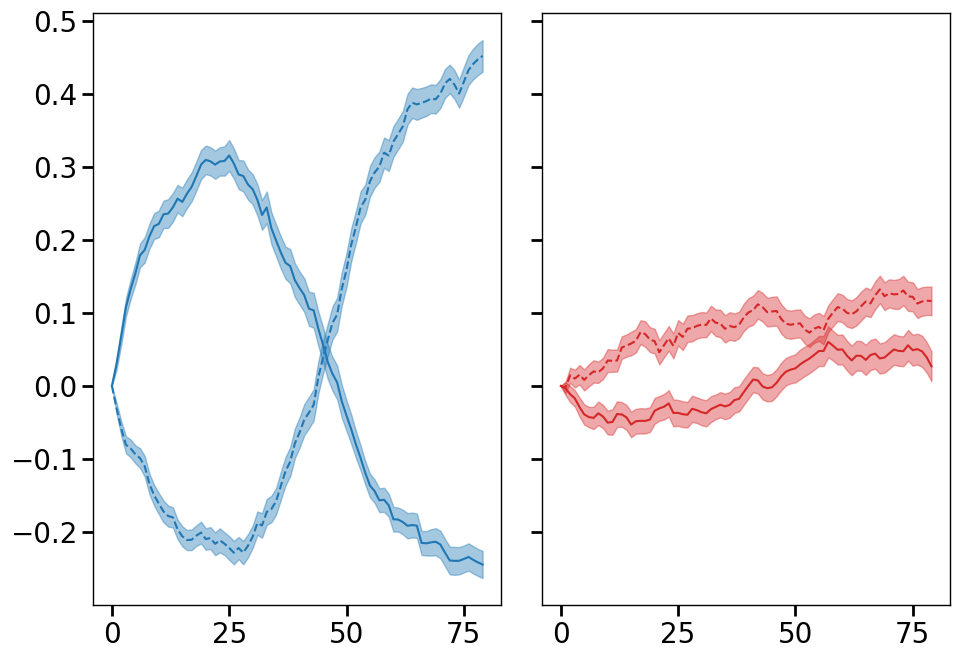

In [76]:
def plot_dW_by_blk_type(synaptic_state_proj, all_saved_states, entry_to_plot, var_key_name):
    where_blk_mask = (all_saved_states['block_type']==0)
    
    num_trials = synaptic_state_proj.shape[1]
    
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
    
    if var_key_name=='loc':
        # find if a session has left or right more rewarding in the beginning
        var_mask = (all_saved_states['reward_probs'][:,0,:,1]<all_saved_states['reward_probs'][:,0,:,0]).squeeze()
    elif var_key_name=='img':
        # find the random stim direction used in that session
        input_diffs = (all_saved_states['inputs'][:,:,0,2:]-all_saved_states['inputs'][:,:,0,:2]).squeeze()/2
        # 
        rewarding_sign = 2*(all_saved_states['reward_probs'][:,0,:,1]<all_saved_states['reward_probs'][:,0,:,0]).squeeze()-1
        
        
    
    proj_mean = (synaptic_state_proj[where_blk_mask&var_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    proj_se = (synaptic_state_proj[where_blk_mask&var_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(where_blk_mask&var_mask))
    axes[0].plot(proj_mean, c='tab:blue', ls='--')
    axes[0].fill_between(np.arange(num_trials), proj_mean-proj_se, proj_mean+proj_se, color='tab:blue', alpha=0.4)
    
    
    proj_mean = (synaptic_state_proj[where_blk_mask&~var_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    proj_se = (synaptic_state_proj[where_blk_mask&~var_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(where_blk_mask&~var_mask))
    axes[0].plot(proj_mean, c='tab:blue')
    axes[0].fill_between(np.arange(num_trials), proj_mean-proj_se, proj_mean+proj_se, color='tab:blue', alpha=0.4)
    
    proj_mean = (synaptic_state_proj[~where_blk_mask&var_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    proj_se = (synaptic_state_proj[~where_blk_mask&var_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(~where_blk_mask&var_mask))
    axes[1].plot(proj_mean, c='tab:red', ls='--')
    axes[1].fill_between(np.arange(num_trials), proj_mean-proj_se, proj_mean+proj_se, color='tab:red', alpha=0.4)
    
    proj_mean = (synaptic_state_proj[~where_blk_mask&~var_mask,:,entry_to_plot[0],entry_to_plot[1]]).mean((0))
    proj_se = (synaptic_state_proj[~where_blk_mask&~var_mask,:,entry_to_plot[0],entry_to_plot[1]]).std((0))/np.sqrt(np.sum(~where_blk_mask&~var_mask))
    axes[1].plot(proj_mean, c='tab:red')
    axes[1].fill_between(np.arange(num_trials), proj_mean-proj_se, proj_mean+proj_se, color='tab:red', alpha=0.4)
    
    fig.tight_layout()
    
    plt.show()
    
plot_dW_by_blk_type(synaptic_state_proj, all_saved_states, [4,6], 'loc')


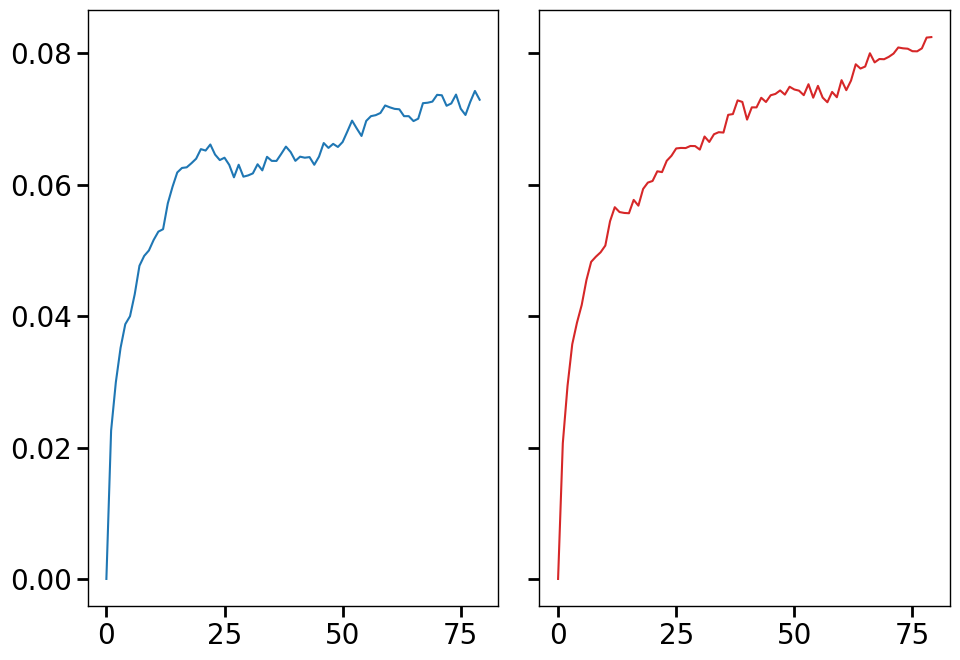

In [83]:
plot_absolute_dW_by_blk_type(synaptic_state_proj, all_saved_states, [6,0], 'loc_chosen')


# Regression analyses (deprecated)

In [156]:
# results_dict = {
#         'model_index': [], # num_blocks
#         'reversal_interval': [], # num_blocks
#         'block_type': [], # num_blocks
#         'stimulus': [], # num_blocks X num_trials
#         'inputs': [], # num_blocks X num_trials X 2*num_dims
#         'img_chosen': [], # num_blocks X num_trials
#         'loc_chosen': [], # num_blocks X num_trials
#         'reward': [], # num_blocks X num_trials
#         'reward_probs': [], # num_blocks X num_trials X 2
#         'neuron_states': [], # num_blocks X num_trials X num_timesteps X num_units
#         'synaptic_states': [] # num_blocks X num_trials X num_units X num_units
#     }

In [178]:
for k, v in all_saved_states.items():
    print(k, v.shape)

model_index (800,)
reversal_interval (800,)
block_type (800,)
stimulus (800, 80, 1)
inputs (800, 80, 1, 4)
img_chosen (800, 80, 1)
loc_chosen (800, 80, 1)
reward (800, 80, 1)
reward_probs (800, 80, 1, 2)
neuron_states (800, 80, 90, 1, 80)
synaptic_states (800, 80, 1, 80, 80)


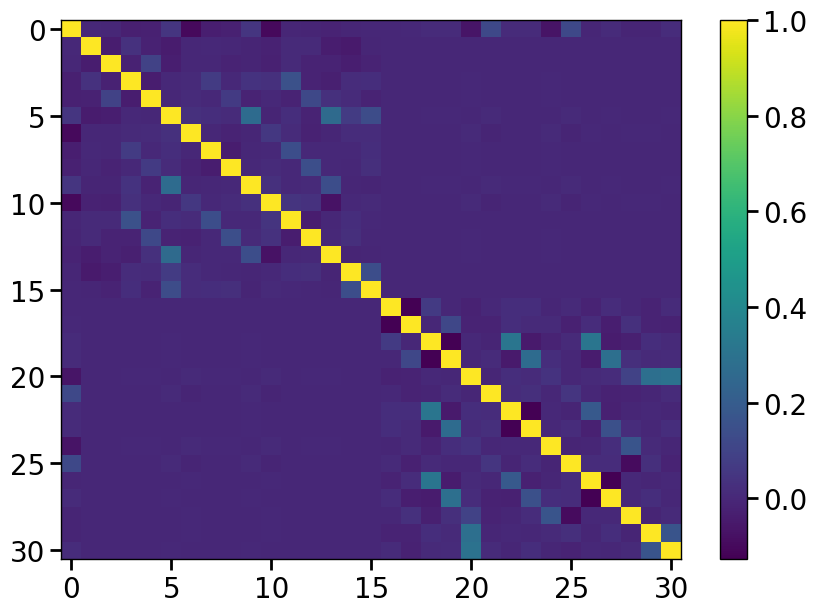

In [179]:
from sklearn.linear_model import LinearRegression

def regression_analysis(all_saved_states):
    '''
    use the saved states to regress the neural activity
    neuron_states ~ inputs (stim_config) + img_chosen + loc_chosen + reward + 
                    prev_img_chosen + prev_loc_chosen + prev_reward +
                    prev_img_chosen*prev_reward + prev_loc_chosen*prev_reward + 
                    prev_img_chosen*inputs + prev_img_chosen*inputs*reward
    '''

    all_mdl_coeffs = []
    
    num_blocks, num_trials, num_timesteps, num_units = all_saved_states['neuron_states'].squeeze().shape

    for mdl_idx in range(all_saved_states['model_index'].max()+1):
        mdl_mask = (all_saved_states['model_index']==mdl_idx)
        mdl_neuron_states = all_saved_states['neuron_states'][mdl_mask]
        
        num_blocks = mdl_neuron_states.shape[0]
        mdl_neuron_states = np.tanh(np.maximum(mdl_neuron_states.squeeze(), 0))

        mdl_stim_config = all_saved_states['inputs'][mdl_mask].squeeze()
        mdl_stim_config = -(mdl_stim_config[...,2:]-mdl_stim_config[...,:2])/2 # (num_blocks, num_trials, 2) 
        # equal to +stim_vector if stim on the left is 0, -stim_vector if stim on the left is 1

        mdl_loc_chosen = all_saved_states['loc_chosen'][mdl_mask].squeeze()*2-1 # (num_blocks, num_trials, ), 1 for right, -1 for left

        # equal to +stim_vector if stim on the left is 0 and loc_chosen is 0, or if stim on the left is 1 and loc_chosen is 1
        # equal to -stim_vector if stim on the left is 1 and loc_chosen is 0, or if stim on the left is 0 and loc_chosen is 1
        # i.e., equal to mdl_stim_config if loc_chosen is 0, or -mdl_stim_config if loc_chosen is 1
        mdl_img_chosen = -mdl_loc_chosen[...,None]*mdl_stim_config # (num_blocks, num_trials, 2)

        mdl_reward = all_saved_states['reward'][mdl_mask].squeeze()*2-1 # (num_blocks, num_trials, ), 1 for rewarded, -1 for unrewarded

        curr_stim_config = mdl_stim_config[:,1:] # (num_blocks, num_trials-1, 2)
        curr_img_chosen = mdl_img_chosen[:,1:] # (num_blocks, num_trials-1, 2)
        curr_loc_chosen = mdl_loc_chosen[:,1:] # (num_blocks, num_trials-1, )
        curr_reward = mdl_reward[:,1:] # (num_blocks, num_trials-1, )

        prev_stim_config = mdl_stim_config[:,:-1] # (num_blocks, num_trials-1, 2)
        prev_img_chosen = mdl_img_chosen[:,:-1] # (num_blocks, num_trials-1, 2)
        prev_loc_chosen = mdl_loc_chosen[:,:-1] # (num_blocks, num_trials-1, )
        prev_reward = mdl_reward[:,:-1] # (num_blocks, num_trials-1, )

        loc_of_chosen_img = np.sign(np.sum(curr_stim_config*prev_stim_config, -1))*prev_loc_chosen # (num_blocks, num_trials-1, )
        loc_of_rewarded_img = prev_reward*loc_of_chosen_img # (num_blocks, num_trials-1, )

        X_by_blocks = []

        for blk_idx in range(2):
            
            blk_mask = all_saved_states['block_type'][mdl_mask]==blk_idx

            X_by_blocks.append(np.concatenate([
                curr_stim_config[blk_mask], # 2
                curr_img_chosen[blk_mask], # 2
                curr_loc_chosen[blk_mask][...,None], # 1
                curr_reward[blk_mask][...,None], # 1
                prev_img_chosen[blk_mask], # 2
                prev_loc_chosen[blk_mask][...,None], # 1
                prev_reward[blk_mask][...,None], # 1
                prev_img_chosen[blk_mask]*prev_reward[blk_mask][...,None], # 2
                (prev_loc_chosen[blk_mask]*prev_reward[blk_mask])[...,None], # 1
                loc_of_chosen_img[blk_mask][...,None], # 1
                loc_of_rewarded_img[blk_mask][...,None], # 1
            ], axis=-1)) # (num_blocks//2, num_trials-1, 15)
            
                        
        X = np.concatenate([
            np.concatenate([-1*np.ones((num_blocks//2, num_trials-1, 1)), X_by_blocks[0], np.zeros_like(X_by_blocks[1])], axis=-1),
            np.concatenate([1*np.ones((num_blocks//2, num_trials-1, 1)), np.zeros_like(X_by_blocks[0]), X_by_blocks[1]], axis=-1),
        ], axis=0) # (num_blocks, num_trials-1, 30)    
                

        curr_mdl_coeffs = []
        for timestep in range(num_timesteps):
            # fit linear model
            mdl = LinearRegression()
            mdl.fit(X.reshape(num_blocks*(num_trials-1), -1), mdl_neuron_states[:,1:,timestep,:].reshape(num_blocks*(num_trials-1), num_units))
            curr_mdl_coeffs.append(mdl.coef_)

        all_mdl_coeffs.append(np.stack(curr_mdl_coeffs))
                
    plt.imshow(np.corrcoef(X.reshape(num_blocks*(num_trials-1), -1).T), aspect='auto')
    plt.colorbar()

    return X, all_mdl_coeffs
        
design_mat, reg_results = regression_analysis(all_saved_states)
        



In [180]:
all_mdl_coef = np.stack(reg_results)


all_mdl_coef_svd = []
all_mdl_time_course_svd = []
all_mdl_var_exp = []

for mdl_idx in range(8):
    curr_mdl_coef_svd = []
    curr_mdl_time_course_svd = []
    curr_mdl_var_exp = []
    for regressor_idx in range(all_mdl_coef.shape[-1]):
        u, s, vh = np.linalg.svd(all_mdl_coef[mdl_idx, ..., regressor_idx], full_matrices=False)
        
        sign = 2*(u[:,0].mean()>0)-1
        curr_mdl_coef_svd.append(sign*vh[0])
        curr_mdl_time_course_svd.append(sign*u[:,0])
        curr_mdl_var_exp.append(s[0]**2/np.sum(s**2))
    
    all_mdl_coef_svd.append(np.stack(curr_mdl_coef_svd, -1))
    all_mdl_time_course_svd.append(np.stack(curr_mdl_time_course_svd, -1))
    all_mdl_var_exp.append(np.stack(curr_mdl_var_exp, -1))

all_mdl_coef_svd = np.stack(all_mdl_coef_svd, 0)
all_mdl_time_course_svd = np.stack(all_mdl_time_course_svd, 0)
all_mdl_var_exp = np.stack(all_mdl_var_exp, 0)

(-0.01, 0.15)

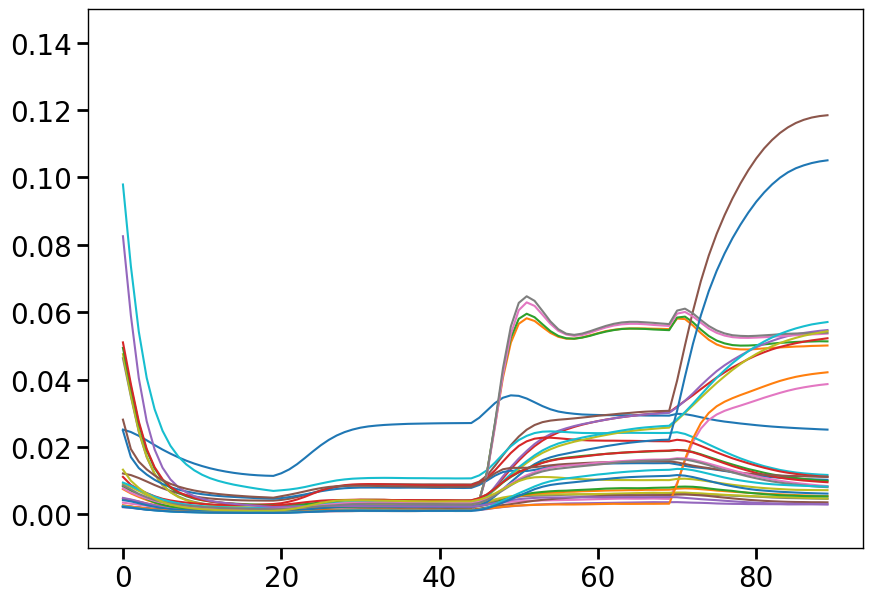

In [185]:
plt.plot(np.abs(all_mdl_coef).mean((0,2))[...,:])
plt.ylim([-0.01, 0.15])

In [186]:
all_mdl_var_exp.mean(0)

array([0.96218728, 0.97875954, 0.97566238, 0.9713781 , 0.96710148,
       0.95427468, 0.9562154 , 0.80181698, 0.7874636 , 0.86483195,
       0.74066483, 0.79624946, 0.81179855, 0.89490533, 0.68154106,
       0.770567  , 0.97608098, 0.97111095, 0.9590202 , 0.95310391,
       0.96729889, 0.97495809, 0.86983675, 0.86173864, 0.88913153,
       0.75413827, 0.89887116, 0.88505565, 0.82605474, 0.81747896,
       0.86555446])

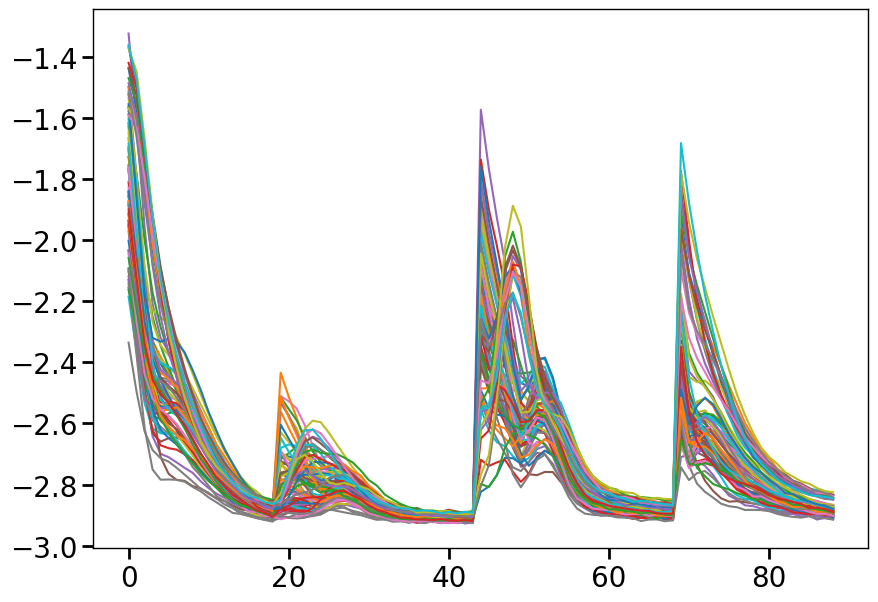

In [187]:
plt.plot(np.log(np.abs(all_saved_states['neuron_states'][:,:,1:]-all_saved_states['neuron_states'][:,:,:-1]).mean((0,1)).squeeze()));

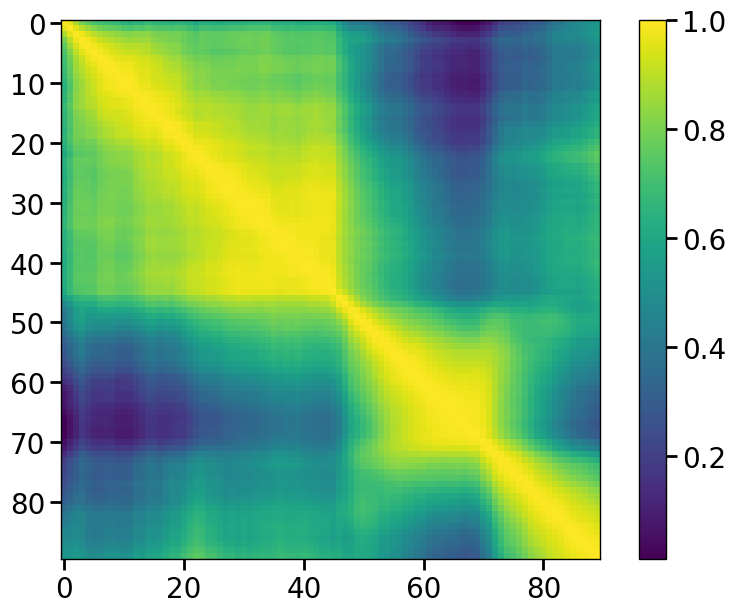

In [194]:
plt.imshow(np.corrcoef(all_mdl_coef[3,:,:,14]))
plt.colorbar()

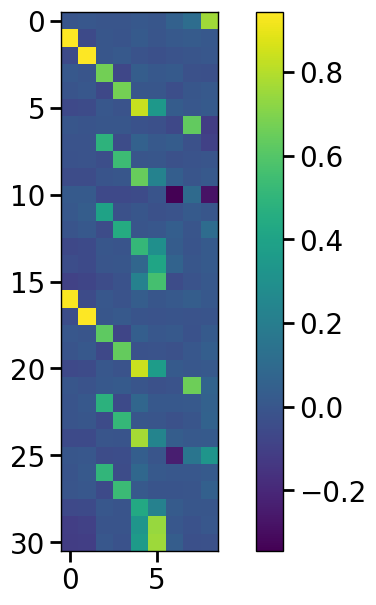

In [189]:
all_coef_bases_overlap = []

for mdl_idx in range(8):
    all_coef_bases_overlap.append(all_mdl_coef_svd[mdl_idx].T@all_model_bases[mdl_idx])
    
plt.imshow(np.mean(all_coef_bases_overlap, 0))
plt.colorbar()

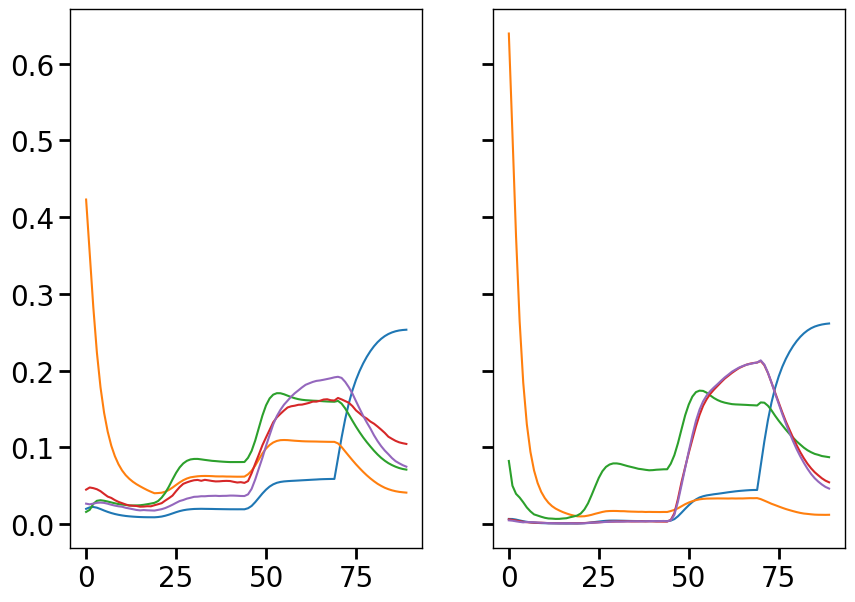

In [190]:
fig, axes = plt.subplots(1, 2, sharey=True)

inds_to_plot = np.array([4, 8, 12, 13, 14])

axes[0].plot(np.abs(all_mdl_time_course_svd[:,...,1+inds_to_plot]).mean(0))
axes[1].plot(np.abs(all_mdl_time_course_svd[:,...,16+inds_to_plot]).mean(0))

In [191]:
# get the encoding axis for choice, block type, loc hist, img hist

# The SVD regression coefficients for each regressor are in all_mdl_coef_svd[mdl_idx, :, regressor_idx]
# Let's extract the axes for choice, block type, loc hist, img hist for each model

# We'll use the following regressor indices (based on the code in cell 48):
# choice: 5 (for block_type=0), 20 (for block_type=1)
# block type: 0
# loc hist: 9, 13 (for block_type=0), 24, 28 (for block_type=1)
# img hist: 14, 15 (for block_type=0), 29, 30 (for block_type=1)

def orthogonalize_ch_hist(ch_axis, hist_axis):
    q, _ = np.linalg.qr(np.stack([ch_axis, hist_axis], axis=1))
    return q[:,-1]

choice_axes = []
block_type_axes = []
loc_hist_axes = []
img_hist_axes = []

for mdl_idx in range(8):
    # Choice axes
    choice_axis_where = all_mdl_coef_svd[mdl_idx, :, 5]
    choice_axis_what = all_mdl_coef_svd[mdl_idx, :, 20]
    choice_axes.append([choice_axis_where, choice_axis_what])

    # Block type axis
    block_type_axis = all_mdl_coef_svd[mdl_idx, :, 0]
    block_type_axes.append(block_type_axis)

    # Loc hist axes: subtract and add the second weights from the first weights to get axes for prev_reward=0 (unr) and prev_reward=1 (rew)
    loc_hist_where_unr = all_mdl_coef_svd[mdl_idx, :, 9] - all_mdl_coef_svd[mdl_idx, :, 13]
#     loc_hist_where_unr = orthogonalize_ch_hist(choice_axis_where, loc_hist_where_unr)
    loc_hist_where_rew = all_mdl_coef_svd[mdl_idx, :, 9] + all_mdl_coef_svd[mdl_idx, :, 13]
#     loc_hist_where_rew = orthogonalize_ch_hist(choice_axis_where, loc_hist_where_rew)
    loc_hist_what_unr = all_mdl_coef_svd[mdl_idx, :, 24] - all_mdl_coef_svd[mdl_idx, :, 28]
#     loc_hist_what_unr = orthogonalize_ch_hist(choice_axis_what, loc_hist_what_unr)
    loc_hist_what_rew = all_mdl_coef_svd[mdl_idx, :, 24] + all_mdl_coef_svd[mdl_idx, :, 28]
#     loc_hist_what_rew = orthogonalize_ch_hist(choice_axis_what, loc_hist_what_rew)
    loc_hist_axes.append([[loc_hist_where_unr, loc_hist_where_rew], [loc_hist_what_unr, loc_hist_what_rew]])

    # Img hist axes: subtract and add the second weights from the first weights to get axes for prev_reward=0 (unr) and prev_reward=1 (rew)
    img_hist_where_unr = all_mdl_coef_svd[mdl_idx, :, 14] - all_mdl_coef_svd[mdl_idx, :, 15]
#     img_hist_where_unr = orthogonalize_ch_hist(choice_axis_where, img_hist_where_unr)
    img_hist_where_rew = all_mdl_coef_svd[mdl_idx, :, 14] + all_mdl_coef_svd[mdl_idx, :, 15]
#     img_hist_where_rew = orthogonalize_ch_hist(choice_axis_where, img_hist_where_rew)
    img_hist_what_unr = all_mdl_coef_svd[mdl_idx, :, 29] - all_mdl_coef_svd[mdl_idx, :, 30]
#     img_hist_what_unr = orthogonalize_ch_hist(choice_axis_what, img_hist_what_unr)
    img_hist_what_rew = all_mdl_coef_svd[mdl_idx, :, 29] + all_mdl_coef_svd[mdl_idx, :, 30]
#     img_hist_what_rew = orthogonalize_ch_hist(choice_axis_what, img_hist_what_rew)
    img_hist_axes.append([[img_hist_where_unr, img_hist_where_rew], [img_hist_what_unr, img_hist_what_rew]])
    
    

# Convert lists to numpy arrays for easier indexing
choice_axes = np.array(choice_axes)  # shape: (8 models, 2 block types, n_units)
block_type_axes = np.array(block_type_axes)  # shape: (8 models, n_units)
loc_hist_axes = np.array(loc_hist_axes)  # shape: (8 models, 2 block types, 2 prev_reward, n_units)
img_hist_axes = np.array(img_hist_axes)  # shape: (8 models, 2 block types, 2 prev_reward, n_units)


In [192]:
# Calculate projections of neural activity onto the SVD regression coefficients
# separate by block type and previous reward

num_blocks, num_trials, num_timesteps, num_units = all_saved_states['neuron_states'].squeeze().shape

all_mdl_proj = {
    'choice_axis': np.nan*np.empty((num_blocks, num_trials-1, num_timesteps)),
    'block_type_axis': np.nan*np.empty((num_blocks, num_trials-1, num_timesteps)),
    'loc_hist_axis_funcs': np.nan*np.empty((num_blocks, num_trials-1, num_timesteps)),
    'img_hist_axis_funcs': np.nan*np.empty((num_blocks, num_trials-1, num_timesteps)),
} # (n_blocks, n_trials-1, n_time)


for mdl_idx in range(8):
    mdl_mask = all_saved_states['model_index'] == mdl_idx # (n_blocks,)
    mdl_neuron_states = all_saved_states['neuron_states'].squeeze()[:,1:,:,:] # (n_blocks, n_trials, n_time, n_units)
    mdl_neuron_states = np.tanh(np.maximum(mdl_neuron_states.squeeze(), 0))
    mdl_neuron_states -= mdl_neuron_states.mean((0,1), keepdims=True) # center the activity

    # choice axis
    for block_type in range(2):
        for prev_reward in range(2):
            block_type_mask = all_saved_states['block_type'] == block_type # (n_blocks,)
            block_type_mask = block_type_mask.squeeze()
            prev_reward_mask = all_saved_states['reward'][:,:-1] == prev_reward # (n_blocks, n_trials-1)
            prev_reward_mask = prev_reward_mask.squeeze()
            block_type_prev_reward_inds = mdl_mask[:,None] & block_type_mask[:,None] & prev_reward_mask # (n_blocks, n_trials-1)

            masked_neuron_states = mdl_neuron_states[block_type_prev_reward_inds] # (n_total_trials, n_time, n_units)
            ch_axis = choice_axes[mdl_idx,block_type][None,None] # (1, 1, n_units)
            loc_hist_axis_funcs = loc_hist_axes[mdl_idx,block_type,prev_reward][None,None] # (1, 1, n_units)
            img_hist_axis_funcs = img_hist_axes[mdl_idx,block_type,prev_reward][None,None] # (1, 1, n_units)
            blk_type_axis = block_type_axes[mdl_idx][None,None]

            all_mdl_proj['choice_axis'][block_type_prev_reward_inds] = \
                (masked_neuron_states*ch_axis).sum(-1) # (n_total_trials, n_time)
            
            all_mdl_proj['loc_hist_axis_funcs'][block_type_prev_reward_inds] = \
                (masked_neuron_states*loc_hist_axis_funcs).sum(-1) # (n_total_trials, n_time)
            
            all_mdl_proj['img_hist_axis_funcs'][block_type_prev_reward_inds] = \
                (masked_neuron_states*img_hist_axis_funcs).sum(-1) # (n_total_trials, n_time)
            
            all_mdl_proj['block_type_axis'][block_type_prev_reward_inds] = \
                (masked_neuron_states*blk_type_axis).sum(-1) 


# Example: plot the mean absolute projection time course for a regressor across all models
# plt.figure(figsize=(10, 7))
# plt.plot(np.mean([np.abs(mdl_proj[...,0]).mean(0) for mdl_proj in all_mdl_proj], axis=0))
# plt.xlabel('Time')
# plt.ylabel('Projection onto SVD regressor 0')
# plt.title('Mean projection time course across models')
# plt.show()


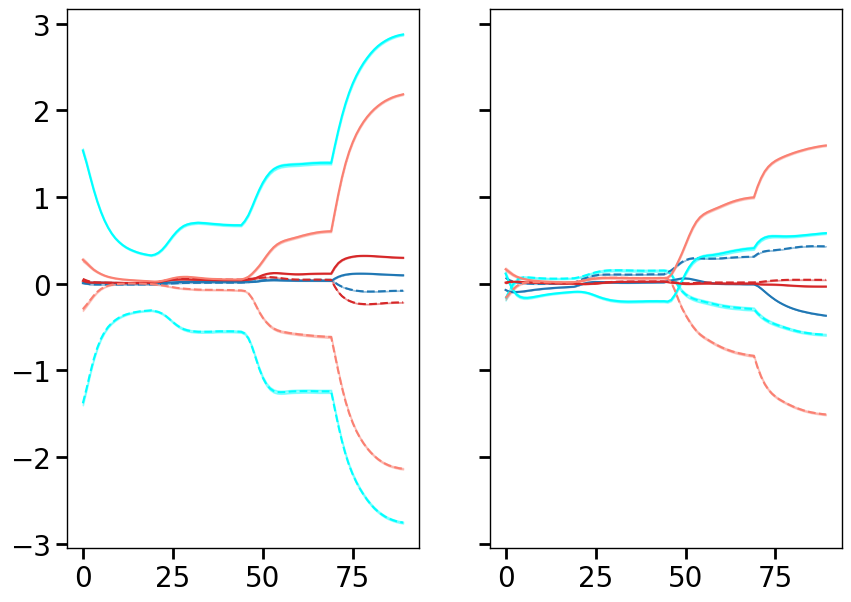

In [193]:
colors = ['tab:blue', 'cyan', 'tab:red', 'salmon']
linestyles = ['--','-']

fig, axes = plt.subplots(1,2, sharey=True)

for block_type in range(2):
    for prev_reward in range(2):
        for curr_choice in range(2):
            block_type_mask = all_saved_states['block_type'] == block_type # (n_blocks,)
            block_type_mask = block_type_mask.squeeze()
            prev_reward_mask = all_saved_states['reward'][:,:-1] == prev_reward # (n_blocks, n_trials-1)
            prev_reward_mask = prev_reward_mask.squeeze()

            ch_mask = all_saved_states['loc_chosen'][:,1:] == curr_choice
            ch_mask = ch_mask.squeeze()

            block_type_prev_reward_inds = block_type_mask[:,None] & prev_reward_mask & ch_mask # (n_blocks, n_trials-1)

            mean_choice_proj = all_mdl_proj['choice_axis'][block_type_prev_reward_inds].mean(0)
            loc_hist_proj = all_mdl_proj['loc_hist_axis_funcs'][block_type_prev_reward_inds].mean(0)
            loc_hist_proj_se = all_mdl_proj['loc_hist_axis_funcs'][block_type_prev_reward_inds].std(0)/np.sqrt(np.sum(block_type_prev_reward_inds))
            img_hist_proj = all_mdl_proj['img_hist_axis_funcs'][block_type_prev_reward_inds].mean(0)
            img_hist_proj_se = all_mdl_proj['loc_hist_axis_funcs'][block_type_prev_reward_inds].std(0)/np.sqrt(np.sum(block_type_prev_reward_inds))
#             plt.scatter(loc_hist_proj[0], mean_choice_proj[0], color='grey')
#             plt.scatter(loc_hist_proj[-1], mean_choice_proj[-1], color='k')
            axes[0].plot(loc_hist_proj, c=colors[block_type*2+prev_reward], ls=linestyles[curr_choice])
            axes[0].fill_between(np.arange(90), loc_hist_proj-loc_hist_proj_se, loc_hist_proj+loc_hist_proj_se,
                                 color=colors[block_type*2+prev_reward], alpha=0.4)
            axes[1].plot(img_hist_proj, c=colors[block_type*2+prev_reward], ls=linestyles[curr_choice])
            axes[1].fill_between(np.arange(90), img_hist_proj-img_hist_proj_se, img_hist_proj+img_hist_proj_se,
                                 color=colors[block_type*2+prev_reward], alpha=0.4)
            

In [126]:
# curr_stim_config, 2
# curr_img_chosen, 2
# curr_loc_chosen[...,None], 1
# curr_reward[...,None], 1
# prev_img_chosen, 2
# prev_loc_chosen[...,None], 1
# prev_reward[...,None], 1
# prev_img_chosen*prev_reward[...,None], 2
# (prev_loc_chosen*prev_reward)[...,None], 1
# loc_of_chosen_img[...,None], 1
# loc_of_rewarded_img[...,None], 1